# U-Net: Redes neuronales convolucionales para segmentación de imágenes biomédicas

Pontificia Universidad Católica del Perú

Escuela de Posgrado PUCP, Maestría en Informática, Ciencias de la Computacion

Curso: 
- Técnicas avanzadas de data mining y sistemas inteligentes

Alumnos:
- 20173589 Alarcon Flores, Jorge Brian
- 20173685 Chicchón Apaza, Miguel Angel
- 20173789 Alvarez Mouravskaia, Kevin
- 20173810 Pacheco Condori, Jesús Edwar

---

## Línea base

- [1] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” CoRR, vol. abs/1505.0, 2015.
- [2] J. Akeret, C. Chang, A. Lucchi, and A. Refregier, “Radio frequency interference mitigation using deep convolutional neural networks,” Astron. Comput., vol. 18, pp. 35–39, 2017.

## Importación de librerías

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
import logging
from collections import OrderedDict
import os
import shutil
from PIL import Image
import h5py
from PIL import Image
import wget #pip install wget
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img #para augmentacion
from tqdm import tqdm_notebook as tqdm
import cv2 #pip install opencv-python
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from joblib import Parallel, delayed #paralelismo pip install joblib

/home/droneulima/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### Configuración de logs

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# Arquitectura de Red Neuronal UNET

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

La arquitectura consiste de una primera parte "contraccion" (Lado izquierdo) y una "expansion" (Lado derecho). 
- La parte de contraccion sigue la arquitectura tipica de una red convolucional. Esta consiste de repetir la 
aplicacion de dos convoluciones 3x3 (unpadded convolucions), cada una seguida por una unidad de rectificacion 
lineal (ReLU) y una operacion de max pooling con stride 2x2 para el downsampling. En cada paso de downsampling 
doblamos el numero de canales de caracteristicas. 
- Cada paso del lado de expansion consiste en un upsampling 
del mapa de caracteristicas seguido por una convolucional 2x2 "up-convolutional" que divide en partes iguales 
el numero de canalaes caracteristicas, luego una concatenacion con el correspondiente mapa de caracteristicas
sesgado obtenido en la contraccion y dos convoluciones 3x3 cada uno seguido por una por un ReLU.
El sesgo (cropping) es necesario debido a la perdida de los pixeles del borde en cada convolucion. 
En la capa final se utiliza una convolucion de 1x1 para mapear cada 64 vector caracteristica al numero deseado 
de clases. 
- En total la red neuronal tiene 23 capas convolucionales. Para permitir ua salida del mapa segmentado sin fisuras, es importante seleccionar el ingreso de imagenes tales que las operaciones son aplicadas a la capa con un tamanio para "x" y "y".

---

## Implementación de tf_unet
- Obtenido de (Akered, 2017)
- Código: https://github.com/jakeret/tf_unet

### util.py
Obtenido de (Akered, 2017)

In [3]:
def plot_prediction(x_test, y_test, prediction, save=False): 
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()

        
def to_rgb(img): 
    #Función que nos permite convertir una matriz en una imagen RGB
    #param img: la matriz que se va a convertir en la imagen RGB
    
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:    #La matriz debe tener 3 canales.
        img = np.tile(img, 3) #En caso de no tener 3 canales, se realiza una transformación mediante la función np.tile
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255          #Finalmente, los valores son reescalados al rango de [0,255) 
    return img  ##Retorna la imagen RGB


def crop_to_shape(data, shape): 
    #Recorta la matriz a la forma de imagen dada quitando el borde
    #:param data: la matriz a recortar
    #:param shape: la forma objetivo del recorte
    
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    return data[:, offset0:(-offset0), offset1:(-offset1)]


def combine_img_prediction(data, gt, pred): 
    #Combina los datos, mejorando la precisión de la predicción en la imagen RGB
    #:param data: parámetro referente a la data a analizar
    #:param gt: parámetro "grouth thruth"; en deep learning, el término "grouth thruth" se refiere a la acción de
                #predicción de la clasificación del conjunto de entrenamiento
    #:param pred: parámetro predicción
   
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img #Retorna la imagen concatenada de RGB


def save_image(img, path): 
    #función que guarda la imagen
    #:param img: la imagen RGB a guardar
    #:param path: la ruta objetivo donde se guardará la imagen RGB
    
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

### layers.py
Obtenido de (Akered, 2017)

In [4]:
def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

### Unet
Obtenido de (Akered, 2017)

In [5]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
                    #Función que nos permite crear una nueva red unet convolucional para la parametrización dada.
    
                    #:param x: tensor input [?,nx,ny,channels]
                    #:param keep_prob: probabilidad marginal del tensor
                    #:param channels: número de canales en la imagen input
                    #:param n_class: número de etiquetas output
                    #:param layers: número de capas en la red
                    #:param features_root: número de capas en la primera red
                    #:param filter_size: tamaño del filtro de convolución
                    #:param pool_size: tamaño de la operación del max pooling
  

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Marcador de posición para la imagen input
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 696
    size = in_size

    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 4
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= 2
                
    in_node = dw_h_convs[layers - 1]

   
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= 2
            size -= 4

    # Mapa Output
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        output_map = tf.nn.relu(conv)
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)

In [6]:
#Implementación de unet
#######################

class Unet(object): 
 
    
    def __init__(self, channels=3, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs): 
        #Inicializamos y definimos parámetros
        tf.reset_default_graph()  

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, n_class], name="y")
        self.keep_prob = tf.placeholder(tf.float32, name="dropout_probability")  # Probabilidad marginal

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)

        self.cost = self._get_cost(logits, cost, cost_kwargs)

        self.gradients_node = tf.gradients(self.cost, self.variables)

        with tf.name_scope("cross_entropy"):
            self.cross_entropy = cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                               tf.reshape(pixel_wise_softmax(logits), [-1, n_class]))

        with tf.name_scope("results"):
            self.predicter = pixel_wise_softmax(logits)
            self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

            
            
    def _get_cost(self, logits, cost_name, cost_kwargs): 
        #Construimos la función de costo

        with tf.name_scope("cost"):
            flat_logits = tf.reshape(logits, [-1, self.n_class])
            flat_labels = tf.reshape(self.y, [-1, self.n_class])
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights)
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                          labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map)

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                                     labels=flat_labels))
            elif cost_name == "dice_coefficient":
                eps = 1e-5
                prediction = pixel_wise_softmax(logits)
                intersection = tf.reduce_sum(prediction * self.y)
                union = eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
                loss = -(2 * intersection / (union))

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None) #Proceso de regularización
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

            return loss

    
    def predict(self, model_path, x_test):  
        #Utilizamos el modelo para crear una predicción para los datos dados
       
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Inicializamos las variables
            sess.run(init)

            # Restaura los pesos del modelo guardado previamente
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction 
    
    
    def save(self, sess, model_path): 
        #Guarda la sesión actual en un checkpoint
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path): 
        #Restaura la sesión de un checkpoint
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [7]:
def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step + 1)))) + (gradients[i] / (step + 1))

    return avg_gradients


def error_rate(predictions, labels): 
    #Devuelve la tasa de error en base a las predicciones densas 
    return 100.0 - ( 100.0 * np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) / 
                    (predictions.shape[0] * predictions.shape[1] * predictions.shape[2]))


def get_image_summary(img, idx=0): 
    #Genera un resumen de la imagen para la imagen del tensor 4d con el índice idx

    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255

    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [8]:
class Trainer(object): 
    #Entrena una instancia de unet

    def __init__(self, net, batch_size=1, verification_batch_size = 12, norm_grads=False, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.verification_batch_size = verification_batch_size
        self.norm_grads = norm_grads
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs

    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)

            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate,
                                                                 global_step=global_step,
                                                                 decay_steps=training_iters,
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,
                                                                               global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate, name="learning_rate")

            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node,
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                           global_step=global_step)

        return optimizer

    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0, name="global_step")

        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]), name="norm_gradients")

        if self.net.summaries and self.norm_grads:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()
        init = tf.global_variables_initializer()

        self.prediction_path = prediction_path
        abs_prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)

        if not restore:
            logging.info("Removing '{:}'".format(abs_prediction_path))
            shutil.rmtree(abs_prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)

        if not os.path.exists(abs_prediction_path):
            logging.info("Allocating '{:}'".format(abs_prediction_path))
            os.makedirs(abs_prediction_path)

        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)

        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1,
              restore=False, write_graph=False, prediction_path='prediction'):
         # Se realiza el proceso de entrenamiento del modelo
        
        save_path = os.path.join(output_path, "model.ckpt")
        if epochs == 0:
            return save_path

        init = self._initialize(training_iters, output_path, restore, prediction_path)

        with tf.Session() as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)

            sess.run(init)

            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)

            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape,_,_,_ = self.store_prediction(sess, test_x, test_y, "_init")

            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")

            avg_gradients = None
            
            # Listas para almacenar las metricas
            losses_train = []
            losses_val = []
            accs_train = []
            accs_val = []
            lrs_train = []
            lrs_val = []
            
            for epoch in range(epochs):
                total_loss = 0
                total_acc = 0  # para acumular accuracy
                for step in range((epoch * training_iters), ((epoch + 1) * training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)
                    # loss, acc, lr -> por iteracion
                    _, loss, acc, lr, gradients = sess.run((self.optimizer, self.net.cost, self.net.accuracy,
                                                            self.learning_rate_node, self.net.gradients_node),
                                                           feed_dict={self.net.x: batch_x, self.net.y: crop_to_shape(
                                                                      batch_y, pred_shape),
                                                                      self.net.keep_prob: dropout})

                    if self.net.summaries and self.norm_grads:
                        avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                        norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                        self.norm_gradients_node.assign(norm_gradients).eval()

                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x,
                                                    crop_to_shape(batch_y, pred_shape))

                    total_loss += loss
                    total_acc += acc # acumulando accuracy

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                # validacion
                _, loss_val, acc_val, lr_val = self.store_prediction(sess, test_x, test_y, "epoch_%s" % epoch)
                
                # agregando metricas de una epoca
                losses_train.append(total_loss/training_iters)
                accs_train.append(total_acc/training_iters)
                lrs_train.append(lr)
                losses_val.append(loss_val)
                accs_val.append(acc_val)
                lrs_val.append(lr_val)

                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            # Variable de salida para metricas
            data_metric = [losses_train, accs_train, lrs_train, losses_val,  accs_val,  lrs_val ]

            return save_path, data_metric

    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,
                                                             self.net.y: batch_y,
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape
        
        # loss, acc, lr -> validacion
        loss, acc, lr = sess.run((self.net.cost, self.net.accuracy, self.learning_rate_node), feed_dict={self.net.x: batch_x,
                                                  self.net.y: crop_to_shape(batch_y, pred_shape),
                                                  self.net.keep_prob: 1.})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                                   crop_to_shape(batch_y,
                                                                                                      prediction.shape)),
                                                                        loss))

        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg" % (self.prediction_path, name))

        # retorna loss, acc, lr
        return pred_shape, loss, acc, lr

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info(
            "Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculamos las métricas
        summary_str, loss, acc, predictions = sess.run([self.summary_op,
                                                        self.net.cost,
                                                        self.net.accuracy,
                                                        self.net.predicter],
                                                       feed_dict={self.net.x: batch_x,
                                                                  self.net.y: batch_y,
                                                                  self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info(
            "Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                           loss,
                                                                                                           acc,
                                                                                                           error_rate(
                                                                                                               predictions,
                                                                                                               batch_y)))
    

### DataProvider
Obtenido de (Akered, 2017)

In [9]:
class BaseDataProvider(object):
  #Clase base abstracta para la implementación de DataProvider. 
  #Esta implementación recorta automáticamente los datos y normaliza los valores a (0,1). 

    channels = 1
    n_class = 2    
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf
        
    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]  
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalización
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
              return data, labels    
    
    def reset_ids(self):
        self._reset_ids();
        
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
    
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
    
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
    
        return X, Y           

In [10]:
class SimpleDataProvider(BaseDataProvider):
    #Proveedor de datos simple para matrices (numpy).
    # Se supone que los datos y la etiqueta son una matriz numpy con las dimensiones
    # data '[n, X, Y, channels]', label '[n, X, Y, classes]''. Donde 'n' es el número de imágenes,
    # 'X', 'Y' del tamaño de la imagen.
    """
    :param data: data numpy array. Shape=[n, X, Y, channels]
    :param label: label numpy array. Shape=[n, X, Y, classes]
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, data, label, a_min=None, a_max=None, channels=1, n_class = 2):
        super(SimpleDataProvider, self).__init__(a_min, a_max)
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class = n_class
        self.channels = channels

    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]

In [11]:
class ImageDataProvider(BaseDataProvider):
    #Proveedor de datos genérico para imágenes, admite escala de grises e imágenes en color.
    
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif', shuffle_data=True, n_class = 2):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        self.data_suffix = data_suffix
        self.mask_suffix = mask_suffix
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame
        self.shuffle_data = shuffle_data
        self.n_class = n_class
        self.data_files = self._find_data_files(search_path)
        
        if self.shuffle_data:
            np.random.shuffle(self.data_files)
        
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 if len(img.shape) == 2 else img.shape[-1]
        
    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files if self.data_suffix in name and not self.mask_suffix in name]
    
    def _load_file(self, path, dtype=np.float32):
        img = np.array(Image.open(path), dtype)
        return img
    
    def _load_tif_file(self, path):
        img_tif = Image.open(path)
        return img_tif

    #Método modificado para soportar frames en los TIF
    def _cylce_file(self):
        if self.file_n_frames == (self.file_frame_idx + 1):
            self.file_idx += 1
            self.file_frame_idx = 0
            if self.file_idx >= len(self.data_files):
                self.file_idx = 0
                self.file_frame_idx = 0
                if self.shuffle_data:
                    np.random.shuffle(self.data_files)
        else:
            self.file_frame_idx += 1
            
        if self.file_idx == -1:
            self.file_idx = 0

    #Método modificado para soportar frames en los TIF
    def _next_data(self):
        self._cylce_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace(self.data_suffix, self.mask_suffix)
        tif_image = self._load_tif_file(image_name)
        tif_label = self._load_tif_file(label_name)
        self.file_n_frames = tif_image.n_frames
        
        if self.file_frame_idx == 0:
            self.file_n_frames_ids = np.arange(0, self.file_n_frames)
            np.random.shuffle(self.file_n_frames_ids)
            
        #print("Image name " + image_name + " - Frame Id: " + str(self.file_n_frames_ids[self.file_frame_idx]) + " - #Frame: " + str(self.file_frame_idx))
        tif_image.seek(self.file_n_frames_ids[self.file_frame_idx])
        tif_label.seek(self.file_n_frames_ids[self.file_frame_idx])
        
        img = np.array(tif_image, np.float32)
        label = np.array(tif_label, np.bool)   
    
        return img,label
    
    #Nuevo metodo para reiniciar los ids
    def _reset_ids(self):
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame

### Generador de Imágenes (toy problem)
Obtenido de (Akered, 2017)

In [12]:
def create_image_and_label(nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
        image = np.ones((nx, ny, 1))
        label = np.zeros((nx, ny, 3), dtype=np.bool)
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt):
            a = np.random.randint(border, nx-border)
            b = np.random.randint(border, ny-border)
            r = np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            y,x = np.ogrid[-a:nx-a, -b:ny-b]
            m = x*x + y*y <= r*r
            mask = np.logical_or(mask, m)

            image[m] = h

        label[mask, 1] = 1

        if rectangles:
            mask = np.zeros((nx, ny), dtype=np.bool)
            for _ in range(cnt//2):
                a = np.random.randint(nx)
                b = np.random.randint(ny)
                r =  np.random.randint(r_min, r_max)
                h = np.random.randint(1,255)

                m = np.zeros((nx, ny), dtype=np.bool)
                m[a:a+r, b:b+r] = True
                mask = np.logical_or(mask, m)
                image[m] = h

            label[mask, 2] = 1

            label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

        image += np.random.normal(scale=sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        if rectangles:
            return image, label
        else:
            return image, label[..., 1] 

In [13]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)   
    
    def _reset_ids(self):
        self

# Pre procesamiento

## Separar imagen TIF

In [14]:
#######################################
#Fuente: elaboración propia
#Clase para separar los frames que una imagen TIF
#Util cuando no se tiene imágenes de test
#######################################
class ImageSeparator:
    
    def __init__(self,
                 image_path_train,
                 image_path_label,
                 activar=False):
        self.image_path_train = image_path_train
        self.image_path_label = image_path_label
        self.activar = activar
    
    def borrar_archivos(self, path):
        for root, dirs, files in os.walk(path):
            for file in files:
                os.remove(os.path.join(root, file))   
    
    def separar_tif(self, image_path_train, image_path_label, path_copy):
        
        if(not self.activar):
            return
        
        path_train = path_copy + "train"
        
        #obtenemos las imágenes y las guardamos en un arreglo
        ids = []
        images_train = []
        ext_img = ".tif"
        image_name = image_path_train[1 * image_path_train.rindex("/") + 1:image_path_train.rindex(ext_img)]
        tif_image = Image.open(image_path_train)
        n_frames = tif_image.n_frames
        print("La imagenes tiene: " + str(n_frames) + " frames/capas")
        for i in range(0, n_frames):
            tif_image.seek(i)
            ids.append(i)
            images_train.append(tif_image.copy())
            
        #obtenemos las imágenes de los label y las guardamos en un arreglo
        images_label = []
        tif_label = Image.open(image_path_label)
        for i in range(0, n_frames):
            tif_label.seek(i)
            images_label.append(tif_label.copy())            

        #borramos los archivos actuales
        self.borrar_archivos(path_train)
        
        #crear carpeta
        if not os.path.lexists(path_train):
            os.mkdir(path_train)        

        #guardamos las imágenes
        for i in range(0, n_frames):
            new_name_file = path_train + "/" + image_name + "-" + str(i)
            images_train[ids[i]].save(new_name_file + ext_img)
            images_label[ids[i]].save(new_name_file + "_mask" + ext_img)
            
        print("Fin de proceso")  

## Aumentacion
Fuente: https://github.com/hansbu/CSE527_FinalProject

### Aumento de cantidad de imágenes

In [15]:
#Fuente: adaptado de https://github.com/hansbu/CSE527_FinalProject
class Augmentation():

    def __init__(self,
                 path_base,
                 path_img,
                 mask_suffix="_mask",
                 img_type="tif",
                 out_rows = 512,
                 out_cols = 512,
                 extra_padding = 180
                ):
        self.path_base = path_base
        self.path_img = path_img
        self.mask_suffix = mask_suffix
        self.img_type = img_type
        self.out_rows = out_rows
        self.out_cols = out_cols
        self.extra_padding = extra_padding
        
        #buscamos las imagenes de entrenamiento
        self.imgs = glob.glob(path_img + "/*[!" + mask_suffix + "]." + img_type)
        self.path_merge = self.path_base + "merge"
        self.path_aug_merge = self.path_base  + "aug_merge"
        self.path_aug_train = self.path_base  + "aug_train"
        
        self.datagen = ImageDataGenerator(
            rotation_range=0.2,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.08,
            zoom_range=0.08,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect') 
        
    def remove_dir(self, path):
        if os.path.lexists(path):
            shutil.rmtree(path, ignore_errors=True)        
    
    def augmentation(self,
                     activar_aug=False,
                     activar_trans=False,
                     continuar=False):
        
        print("Inicio augmentación")
        imgs = self.imgs
        path_merge = self.path_merge
        path_aug_merge = self.path_aug_merge
        self.activar_aug = activar_aug
        self.activar_trans = activar_trans
        self.continuar = continuar
        
        self.remove_dir(path_aug_merge)
        if not os.path.lexists(path_aug_merge):
            os.makedirs(path_aug_merge) 
         
        if self.activar_aug:
            self.remove_dir(self.path_aug_train)
            for i in tqdm(range(len(imgs))):
                label_img = imgs[i][:-1 * (len(self.img_type)+1)] + self.mask_suffix + "." + self.img_type;
                img_t = load_img(imgs[i])
                img_l = load_img(label_img)
                x_t = img_to_array(img_t)
                x_l = img_to_array(img_l)
                x_t[:, :, 2] = x_l[:, :, 0] 

                if not os.path.lexists(path_merge):
                    os.mkdir(path_merge)

                img_tmp = array_to_img(x_t)
                img_tmp.save(path_merge + "/" + str(i) + "." + self.img_type)
                img = x_t
                img = img.reshape((1,) + img.shape)

                savedir = path_aug_merge + "/" + str(i)  
                if not os.path.lexists(savedir):
                    os.mkdir(savedir)

                self.doAugmentate(img, savedir, str(i)) 
                self.split_merge(self.activar_aug) 
        else:
            print("Augmentacion desactivada")
        
        #borramos las carpetas ya usadas
        self.remove_dir(path_aug_merge)
        self.remove_dir(path_merge)   
        
        #transformacion
        data_process = DataProcess(path_base=self.path_base, 
                                   path_img=self.path_img, 
                                   out_rows = self.out_rows,
                                   out_cols = self.out_cols,
                                   extra_padding = self.extra_padding
                                  )
        data_process.create_train_data(self.activar_trans, self.continuar)
        
        #borramos las carpetas ya usadas
        #self.remove_dir(self.path_aug_train)
        
    def doAugmentate(self,
                     img,
                     save_to_dir,
                     save_prefix,
                     batch_size=1,
                     save_format='tif',
                     imgnum=50):

        # augmentate one image
        datagen = self.datagen
        i = 0
        for batch in datagen.flow(
                img,
                batch_size=batch_size,
                save_to_dir=save_to_dir,
                save_prefix=save_prefix,
                save_format=save_format):
            i += 1
            if i > imgnum:
                break      
                
    def split_merge(self,
                    activar=False):
        
        if(not activar):
            return
        
        path_merge = self.path_aug_merge
        path_train = self.path_aug_train
            
        if not os.path.lexists(path_train):
            os.makedirs(path_train)            

        for i in tqdm(range(len(self.imgs))):       
            path = path_merge + "/" + str(i)
            train_imgs = glob.glob(path + "/*." + self.img_type) # add subfolder 0 --> 29
            savedir = path_train + "/" + str(i)
            
            if not os.path.lexists(savedir):
                os.mkdir(savedir)
                
            for imgname in train_imgs:
                imgname = imgname.replace("\\","/")
                midname = imgname[imgname.rindex("/") + 1:imgname.rindex(
                    "." + self.img_type)]
                img = cv2.imread(imgname)
                img_train = img[:, :, 2]  #cv2 read image rgb->bgr
                img_label = img[:, :, 0]
                cv2.imwrite(path_train + "/" + str(i) + "/" + midname + ""
                            + "." + self.img_type, img_train)
                cv2.imwrite(path_train + "/" + str(i) + "/" + midname + self.mask_suffix
                            + "." + self.img_type, img_label)   

### Elastic Transform

In [16]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

### Procesamiento

In [17]:
def input_filled_mirroring(x, e = 62):      # fill missing data by mirroring the input image
    '''input size 636 --> output size 512'''
    # w, h = x.shape
    w, h = np.shape(x)[0], np.shape(x)[1]
    #e = 62  # extra width on 1 edge
    y = np.zeros((h + e * 2, w + e * 2))
    y[e:h + e, e:w + e] = x
    y[e:e + h, 0:e] = np.flip(y[e:e + h, e:2 * e], 1)  # flip vertically
    y[e:e + h, e + w:2 * e + w] = np.flip(y[e:e + h, w:e + w], 1)  # flip vertically
    y[0:e, 0:2 * e + w] = np.flip(y[e:2 * e, 0:2 * e + w], 0)  # flip horizontally
    y[e + h:2 * e + h, 0:2 * e + w] = np.flip(y[h:e + h, 0:2 * e + w], 0)  # flip horizontally
    return y

In [18]:
class DataProcess():
    
    def __init__(self,
                 path_base,
                 path_img,
                 out_rows = 512,
                 out_cols = 512,
                 extra_padding = 180,
                 mask_suffix="_mask",
                 img_type="tif"
                 ):
        self.path_base = path_base
        self.path_aug_train = path_base + "aug_train"
        self.path_aug_test = path_base + "aug_test"
        self.out_cols = out_cols
        self.out_rows = out_rows
        self.extra_padding = extra_padding
        self.imgs = glob.glob(path_img + "/*[!" + mask_suffix + "]." + img_type)
        self.mask_suffix = mask_suffix
        self.img_type = img_type
        self.path_aug_trans_train = path_base + "aug_trans_train"
        
    def create_train_data(self,
                          activar=False,
                          continuar=False):
        
        print("Inicio transformación y deformación")
        if(not activar):
            return
        
        extra = self.extra_padding
        ET_params = np.array([[2, 0.08, 0.08], [2, 0.05, 0.05], [3, 0.07, 0.09], [3, 0.12, 0.07]]) * self.out_cols
        len_scaled = len(ET_params) + 1
        len_imgs = len(self.imgs)
        mask_suffix = self.mask_suffix
        
        imgdatas = np.ndarray(
            (len_imgs*len_scaled, 1, self.out_rows+extra, self.out_cols+extra), dtype=np.uint8)
        imglabels = np.ndarray(
            (len_imgs*len_scaled, 1, self.out_rows, self.out_cols), dtype=np.uint8)
        
        #solo borro carpetas cuando continuo
        if not continuar:
            if os.path.lexists(self.path_aug_trans_train):
                shutil.rmtree(self.path_aug_trans_train, ignore_errors=True)
                
        if not os.path.lexists(self.path_aug_trans_train):
            os.makedirs(self.path_aug_trans_train)              
        
        for i in tqdm(range(len_imgs)):
            train_foldername = self.path_aug_train + "/" + str(i)
            imgs = glob.glob(train_foldername + "/*[!" + mask_suffix + "]." + self.img_type)
            
            #si encuentra carpeta pasamos a siguiente iteración
            dir_continue = self.path_aug_trans_train + "/" + str(i)
            if os.path.lexists(dir_continue) and continuar:
                continue
            
            for imgname in tqdm(imgs):
                label_img = imgname[:-1 * (len(self.img_type)+1)] + self.mask_suffix + "." + self.img_type;
                imgname = imgname.replace("\\","/")
                name = imgname[imgname.rindex("/") + 1:-1 * (len(self.img_type)+1)]
                
                img = load_img(imgname, grayscale=True)
                label = load_img(label_img, grayscale=True)
                img = np.array(img)         # size of 512x512
                label = np.array(label)     # size of 512x512
                
                #  add elastic transform here!!!
                im_merge = np.concatenate((img[..., None], label[..., None]), axis=2)
                # print("size of im_merge: ", im_merge.shape)
                for k in range(len(ET_params) + 1):
                    if k > 0:   # index 0 is for the original image
                        im_merge_t = elastic_transform(im_merge, ET_params[k-1,0], ET_params[k-1,1],ET_params[k-1,2])
                        # Split image and mask
                        img = im_merge_t[..., 0]
                        label = im_merge_t[..., 1]                   
                        
                    # original code for only 1 image augmentation
                    # We also applied the Overlap-tile strategy for seamless segmentation as suggested by the paper, 
                    #     missing data at 4 edges are extrapolated by mirroring.
                    img = input_filled_mirroring(img, e=int(extra/2))
                    label = input_filled_mirroring(label, e=int(extra/2))  
                    
                    # guardar imagen
                    im = Image.fromarray(img.round().astype(np.uint8))
                    im_label = Image.fromarray(label.round().astype(np.uint8))
                    savedir = self.path_aug_trans_train + "/" + str(i)
                    if not os.path.lexists(savedir):
                        os.mkdir(savedir)
                    im.save(savedir + "/" + name + ".tif")
                    im_label.save(savedir + "/" + name + "_mask.tif") 

### Separación conjunto de pruebas y entrenamiento

In [19]:
class SplitDataset():
    def __init__(self, path_base, train_path):
        self.path = path_base
        self.train_path = path_base + train_path
        
    def split(self, percent_test, activar=True):
        
        if not activar:
            return
        else:
            if os.path.lexists(self.path + "final-train/"):
                shutil.rmtree(self.path + "final-train/", ignore_errors=True) 
            if os.path.lexists(self.path + "final-test/"):
                shutil.rmtree(self.path + "final-test/", ignore_errors=True)                 
        
        dirs = os.listdir(self.train_path)
        np.random.seed(98765)
        np.random.shuffle(dirs)
        total = len(dirs)
        test = int((percent_test * total) / 100)
        train = total - test
        print("Total de folders para conjuntos de test: " + str(test))
        print("Total de folders para conjuntos de entrenamiento: " + str(train))
        for i in range(0, train):
            shutil.copytree(self.train_path + dirs[i] + "/", self.path + "final-train/" + dirs[i])
        for i in range(train, total):
            shutil.copytree(self.train_path + dirs[i] + "/", self.path + "final-test/" + dirs[i])             

# Entrenamiento y pruebas
Pruebas con diferentes conjuntos de datos
- Utilizar imágenes del formato TIFF. 
- Se recomienda visualizar las imágenes con el siguiente editor: https://fiji.sc/
- Cada prueba tiene una variable que comienza con ENTRENAR (Ej. ENTRENAR_BROAD_TOY_PROBLEM_MODEL). Esa variable indica si vamos a reutilizar un modelo ya entrenado o vamos a entrenar de nuevo. Se recomienda que sea True al entrenar y luego pasarlo a False. 

### Implementacion de U-Net con Tensorflow


#### Paso1: Definimos la red UNET

- Definimos la red U-Net

```python
Unet(channels=3, n_class=2, cost=u'cross_entropy', cost_kwargs={}, **kwargs)
```

- Donde:	
    - channels:(Opcional) Numero de canales en la imagen de entrada
    - n_class: (Opcional) Numero de clases de salida.
    - cost:(Opcional) Nombre de la funcion de costo. Por defecto es ‘cross_entropy’
    - cost_kwargs: (Opcional) Argumentos para la funcion costo. Ver funcion costo.
    
    - Ejemplo:
    ```python
net = Unet(channels=1, n_class=2, layers=3, features_root=64)
    ```

    - channels: Como utilizamos imagenes en escala de grises, se asigno el valor de channels=1. Para el caso de utilizar imagenes en color RGB, el numero de canales deberia ser channels=3.
    - n_class: El objetivo de la U-Net es predecir un problema binario, por l que las clases se asignarion a class=2.
    - layers: El numero de capas  o niveles de la arquitectura de la UNET se definio a Layers=3.
    - features_root: El numero de caracteristicas en la primera capa, por lo que features_root=16

#### Paso 2: Definimos el Entrenamiento 

- Definimos el objeto de entrenamiento

```python
trainer = Trainer(net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}
```

- Donde:
    - net: Es la instancia a entrenar.
    - batch_size: Es el tamanio batch a entrenar, para dataset con gran volumen de data.
    - verification_batch_size: (Opcional) tamanio de verifiacion del batch. Valor por defecto 4.
    - norm_grads: (Opcional) true si las gradientes normalizadas deberia ser agregados al resumen, por defecto False.
    - optimizer: (Opcional) nombre del optimizador a utilizar peude ser momentum or adam, por defecto el primero.
    - opt_kwargs: (Opcional) kwargs pasado para el grado de aprendiazje (momentum opt) and al optimizador.

    - Ejemplo: 
    ```python
    trainer = Trainer(net, trainers_iters=32, epochs=100, batch_size=500)
    ```

#### Paso 3: Ejecutamos la red entrenada

- Definimos el objeto de Predicion

```python
prediction = model.predict(output_path, x_test)
```

- Donde:
    - output_path: indicandole la ruta donde se encuentra el archivo con el modelo entrenado.
    - x_test: Data a predecir en la red. De la forma [n, nx, ny, channels]

    - Ejemplo: 
    ```python
    prediction = model.predict(output_path, x_test)
    ```

In [20]:
#######################################
#Fuente: elaboración propia
#Clase que se invoca para entrenar los modelos y probarlos
#######################################
class Pruebas():
    
    def get_image_plt(self, image_array, index):
        return to_rgb(image_array[0,...,index]).round().astype(np.uint8)
    
    def train(self, data_provider, trained_folder, training_iters=32, epochs=10, batch_size=1, 
              layers=3, features=16, momentum=0.2, train = True):
        #TODO: solo muestra la primera imagen
        x_train, y_train = data_provider(1)   
        
        #Convertimos las imagenes para no perder información al graficar
        x_img = self.get_image_plt(x_train, 0)
        y_img = self.get_image_plt(y_train, 1)
        
        data_provider.reset_ids()
        
        #Graficar
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto") 
        plt.show()
        
        #Entrenar
        net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=layers, features_root=features)
        trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=momentum), batch_size=batch_size)
        data_metric = None
        if train:
            path, data_metric = trainer.train(data_provider, "./" + trained_folder, 
                                 training_iters = training_iters, 
                                 epochs = epochs, 
                                 display_step = 2, 
                                 prediction_path='prediction_' + trained_folder, 
                                 restore = False, 
                                 write_graph = False)
        return net, data_metric
        
    def test(self, model, data_provider, trained_folder):
        #TODO: solo muestra la primera imagen
        x_test, y_test = data_provider(1)
        #Predicción
        prediction = model.predict("./" + trained_folder + "/model.ckpt", x_test)
        
        #Convertimos las imagenes para no perder información al grafica
        x_img = self.get_image_plt(x_test, 0)
        y_img = self.get_image_plt(y_test, 1)
        pred_img = self.get_image_plt(prediction, 1)
        
        #Graficar
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
        ax[0].set_title("Input")
        ax[1].set_title("Ground truth")
        ax[2].set_title("Prediction")
        
        ny = prediction.shape[2]
        ch = x_test.shape[3]
        x_img = to_rgb(crop_to_shape(x_test, prediction.shape).reshape(-1, ny, ch)).round().astype(np.uint8)
        y_img = to_rgb(crop_to_shape(y_test[..., 1], prediction.shape).reshape(-1, ny, 1))
        
        
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto")
        ax[2].imshow(pred_img, aspect="auto")
        fig.tight_layout()
        
        #Guardamos imagen para documentación
        fig.savefig("img/"+ "./" + trained_folder+".png") 
        
        fig1, a1x = plt.subplots(1, 1, sharex=True, sharey=True)
        a1x.set_axis_off()
        a1x.imshow(y_img, aspect="auto")
        fig1.savefig("img/"+ "./" + trained_folder+"_Ground_1.tif",bbox_inches='tight')
        
        fig2, a2x = plt.subplots(1, 1, sharex=True, sharey=True)
        a2x.set_axis_off()
        a2x.imshow(pred_img, aspect="auto")
        fig2.savefig("img/"+ "./" + trained_folder+"_Predict_2.tif",bbox_inches='tight')
    

In [21]:
#######################################
#Fuente: elaboración propia
#Función para mostrar métricas
#######################################

def show_results(data_metric):
    losses_train = data_metric[0]
    accs_train   = data_metric[1]
    lrs_train     = data_metric[2]
    losses_val   = data_metric[3]
    accs_val     = data_metric[4]
    lrs_val       = data_metric[5]
        
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    ax1, ax2, ax3 = axes
    ax1.plot(losses_train, label='train')
    ax1.plot(losses_val, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    plt.tight_layout(pad=0.5, w_pad=1.0, h_pad=1.0)
    ax2.plot(accs_train, label='train')
    ax2.plot(accs_val, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    plt.tight_layout(pad=0.5, w_pad=1.0, h_pad=1.0)
    ax3.plot(lrs_train, label='train')
    ax3.plot(lrs_val, label='test')
    ax3.set_xlabel('epoch'); ax3.set_ylabel('learning rate')
    for ax in axes: ax.legend()

### demo_toy_problem
- Demos obtenidos del repositorio https://github.com/jakeret/tf_unet
- Crea una imágen con valores aleatóreos

In [22]:
TRAINED_FOLDER_TOY_PROBLEM = "unet_trained_toy_problem"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_TOY_PROBLEM_MODEL = False

In [23]:
def generar_toy_image():
    nx = 572
    ny = 572
    plt.rcParams['image.cmap'] = 'gist_earth'
    np.random.seed(98765)
    return GrayScaleDataProvider(nx, ny, cnt=20);

Train

In [24]:
data_provider_toy_problem_train = generar_toy_image()

In [25]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_toy_problem = Pruebas();

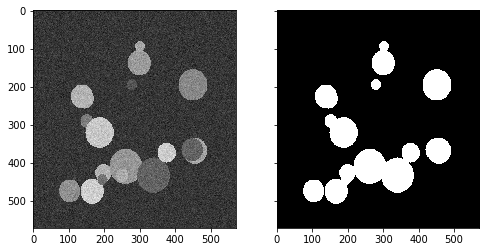

2018-10-09 18:14:45,133 Layers 5, features 32, filter size 3x3, pool size: 2x2


In [26]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_toy_problem, data_metric = pruebas_toy_problem.train(data_provider_toy_problem_train, 
                                              TRAINED_FOLDER_TOY_PROBLEM, 
                                              32, #iterations
                                              10, #epoch
                                              1, #batch size
                                              5, #layers
                                              32, #features
                                              0.5, #momentum
                                              ENTRENAR_BROAD_TOY_PROBLEM_MODEL)

Métricas

In [27]:
if (data_metric is not None):
    show_results(data_metric)

Test

In [28]:
data_provider_toy_problem_test = data_provider_toy_problem_train

INFO:tensorflow:Restoring parameters from ./unet_trained_toy_problem/model.ckpt


2018-10-08 09:57:04,285 Restoring parameters from ./unet_trained_toy_problem/model.ckpt
2018-10-08 09:57:04,545 Model restored from file: ./unet_trained_toy_problem/model.ckpt


(1, 388, 388, 2)
(1, 572, 572, 2)
388
1


2018-10-08 09:57:07,378 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


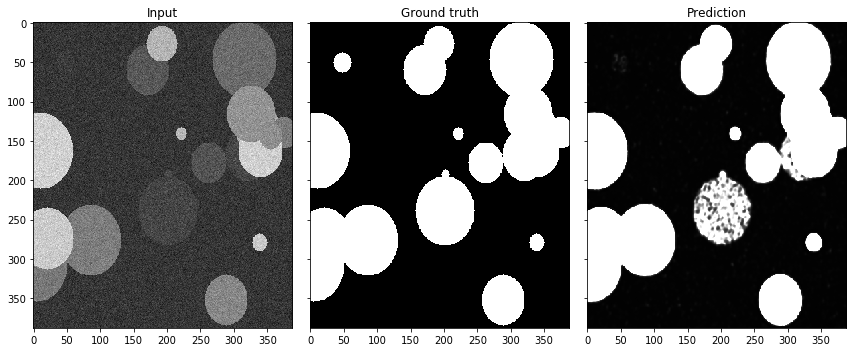

In [29]:
pruebas_toy_problem.test(model_toy_problem, data_provider_toy_problem_test, TRAINED_FOLDER_TOY_PROBLEM)

### EM segmentation challenge - ISBI 2012 (línea base)
- http://brainiac2.mit.edu/isbi_challenge/
- Es la que usan en el paper base (Ronneberger et al., 2015)
- Resolución: 512 x 512 x 30
- No existen imágenes de máscaras para conjunto de pruebas

In [31]:
PATH_ISBI_2012 = "dataset/isbi-challenge/" #path base del dataset
PATH_ISBI_2012_TRAIN = "dataset/isbi-challenge/train/" #path donde estan las imagenes originales
PATH_ISBI_2012_FINAL_TEST = PATH_ISBI_2012 + "final-test/"
PATH_ISBI_2012_FINAL_TRAIN = PATH_ISBI_2012 + "final-train/"
TRAINED_FOLDER_ISBI_2012 = "unet_trained_isbi_2012"

PATH_ISBI_2012_TEST_ORIGINAL = "dataset/isbi-challenge/test-original/"
PATH_ISBI_2012_TEST_MASK = "dataset/isbi-challenge/test-mask/"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_ISBI_2012_MODEL = True

Pre-Train

In [32]:
def pre_train_isbi_challenge():
    IMAGE_PATH_TRAIN = "dataset/isbi-challenge/original/train-volume.tif"
    IMAGE_PATH_LABEL = "dataset/isbi-challenge/original/train-labels.tif"
    
    #separamos los archivos tif
    image_separator = ImageSeparator(IMAGE_PATH_TRAIN, IMAGE_PATH_LABEL, activar=True)
    image_separator.separar_tif(IMAGE_PATH_TRAIN, IMAGE_PATH_LABEL, PATH_ISBI_2012) 
    
    #augmentacion
    augmentation = Augmentation(
        path_base=PATH_ISBI_2012, 
        path_img=PATH_ISBI_2012_TRAIN,
        out_rows = 512,
        out_cols = 512,
        extra_padding = 0) #mirroring
    
    # activar_aug (True = vuelve a generar las imagenes)
    # activar_trans (True = vuelve a distorsionar las imagenes)
    # continuar (True = continuar donde dejaste el proceso de distorsión, ya que demoran mucho en generar)
    augmentation.augmentation(activar_aug=False, activar_trans=False, continuar=False)
    
    #separar conjunto de pruebas y entrenamiento
    split = SplitDataset(PATH_ISBI_2012, "aug_trans_train/")
    split.split(20, activar=False)
    
pre_train_isbi_challenge()

La imagenes tiene: 30 frames/capas
Fin de proceso
Inicio augmentación
Augmentacion desactivada
Inicio transformación y deformación


Train

In [33]:
data_provider_isbi_2012_train = ImageDataProvider(PATH_ISBI_2012_FINAL_TRAIN + "/*/" + "*.tif")

Number of files used: 1180


In [34]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_isbi_2012 = Pruebas();

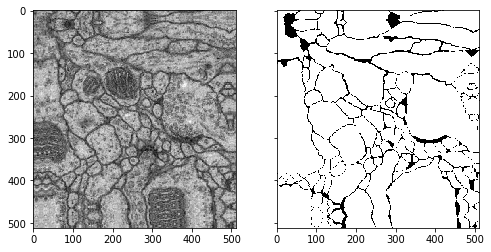

2018-10-09 21:54:44,637 Layers 5, features 64, filter size 3x3, pool size: 2x2
2018-10-09 21:54:47,273 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_isbi_2012'
2018-10-09 21:54:47,276 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_isbi_2012'
2018-10-09 21:54:47,305 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_isbi_2012'
2018-10-09 21:54:47,307 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_isbi_2012'
2018-10-09 21:54:50,375 Verification error= 11.0%, loss= 0.6247
2018-10-09 21:54:51,299 Start optimization
2018-10-09 21:54:55,761 Iter 0, Minibatch Loss= 0.5015, Training Accuracy= 0.8661, Minibatch error= 13.4%
2018-10-09 21:54:59,131 Iter 2, Minibatch Loss= 0.4588, Training Accuracy= 0.8885, Minibatch error= 11.1%
2018-10-09 21:55:02,550 Iter 4, Minibatch Loss= 0.3601, Training Accuracy= 0.8800, Minibatch error= 12.0%
2018-10-09 21:55:06,26

2018-10-09 21:58:39,867 Iter 130, Minibatch Loss= 0.2516, Training Accuracy= 0.8882, Minibatch error= 11.2%
2018-10-09 21:58:43,008 Iter 132, Minibatch Loss= 0.2647, Training Accuracy= 0.8643, Minibatch error= 13.6%
2018-10-09 21:58:46,275 Iter 134, Minibatch Loss= 0.2427, Training Accuracy= 0.8859, Minibatch error= 11.4%
2018-10-09 21:58:49,487 Iter 136, Minibatch Loss= 0.2579, Training Accuracy= 0.8861, Minibatch error= 11.4%
2018-10-09 21:58:52,748 Iter 138, Minibatch Loss= 0.2746, Training Accuracy= 0.8801, Minibatch error= 12.0%
2018-10-09 21:58:56,143 Iter 140, Minibatch Loss= 0.2470, Training Accuracy= 0.8788, Minibatch error= 12.1%
2018-10-09 21:58:59,421 Iter 142, Minibatch Loss= 0.2255, Training Accuracy= 0.8934, Minibatch error= 10.7%
2018-10-09 21:59:02,587 Iter 144, Minibatch Loss= 0.2503, Training Accuracy= 0.8797, Minibatch error= 12.0%
2018-10-09 21:59:05,710 Iter 146, Minibatch Loss= 0.2575, Training Accuracy= 0.8901, Minibatch error= 11.0%
2018-10-09 21:59:08,995 Iter

2018-10-09 22:02:38,602 Iter 270, Minibatch Loss= 0.2503, Training Accuracy= 0.8892, Minibatch error= 11.1%
2018-10-09 22:02:41,786 Iter 272, Minibatch Loss= 0.2284, Training Accuracy= 0.8960, Minibatch error= 10.4%
2018-10-09 22:02:44,922 Iter 274, Minibatch Loss= 0.2607, Training Accuracy= 0.8808, Minibatch error= 11.9%
2018-10-09 22:02:48,118 Iter 276, Minibatch Loss= 0.2278, Training Accuracy= 0.9034, Minibatch error= 9.7%
2018-10-09 22:02:51,212 Iter 278, Minibatch Loss= 0.2474, Training Accuracy= 0.8919, Minibatch error= 10.8%
2018-10-09 22:02:54,240 Iter 280, Minibatch Loss= 0.2716, Training Accuracy= 0.8758, Minibatch error= 12.4%
2018-10-09 22:02:57,204 Iter 282, Minibatch Loss= 0.2332, Training Accuracy= 0.9006, Minibatch error= 9.9%
2018-10-09 22:03:00,268 Iter 284, Minibatch Loss= 0.2098, Training Accuracy= 0.9037, Minibatch error= 9.6%
2018-10-09 22:03:03,436 Iter 286, Minibatch Loss= 0.2424, Training Accuracy= 0.8961, Minibatch error= 10.4%
2018-10-09 22:03:04,013 Epoch 8

2018-10-09 22:06:32,148 Iter 410, Minibatch Loss= 0.2090, Training Accuracy= 0.9000, Minibatch error= 10.0%
2018-10-09 22:06:35,178 Iter 412, Minibatch Loss= 0.2445, Training Accuracy= 0.8809, Minibatch error= 11.9%
2018-10-09 22:06:38,182 Iter 414, Minibatch Loss= 0.2066, Training Accuracy= 0.9056, Minibatch error= 9.4%
2018-10-09 22:06:38,758 Epoch 12, Average loss: 0.2429, learning rate: 0.1081
2018-10-09 22:06:39,599 Verification error= 10.4%, loss= 0.2353
2018-10-09 22:06:45,034 Iter 416, Minibatch Loss= 0.2358, Training Accuracy= 0.8938, Minibatch error= 10.6%
2018-10-09 22:06:48,090 Iter 418, Minibatch Loss= 0.2257, Training Accuracy= 0.8965, Minibatch error= 10.3%
2018-10-09 22:06:51,276 Iter 420, Minibatch Loss= 0.2225, Training Accuracy= 0.8974, Minibatch error= 10.3%
2018-10-09 22:06:54,307 Iter 422, Minibatch Loss= 0.2375, Training Accuracy= 0.8945, Minibatch error= 10.6%
2018-10-09 22:06:57,376 Iter 424, Minibatch Loss= 0.2127, Training Accuracy= 0.9002, Minibatch error= 1

2018-10-09 22:10:24,742 Iter 548, Minibatch Loss= 0.2169, Training Accuracy= 0.9031, Minibatch error= 9.7%
2018-10-09 22:10:27,781 Iter 550, Minibatch Loss= 0.2744, Training Accuracy= 0.8723, Minibatch error= 12.8%
2018-10-09 22:10:30,860 Iter 552, Minibatch Loss= 0.2837, Training Accuracy= 0.8618, Minibatch error= 13.8%
2018-10-09 22:10:33,965 Iter 554, Minibatch Loss= 0.2234, Training Accuracy= 0.9009, Minibatch error= 9.9%
2018-10-09 22:10:37,076 Iter 556, Minibatch Loss= 0.1946, Training Accuracy= 0.9115, Minibatch error= 8.9%
2018-10-09 22:10:40,152 Iter 558, Minibatch Loss= 0.2131, Training Accuracy= 0.9033, Minibatch error= 9.7%
2018-10-09 22:10:43,376 Iter 560, Minibatch Loss= 0.2186, Training Accuracy= 0.9016, Minibatch error= 9.8%
2018-10-09 22:10:46,429 Iter 562, Minibatch Loss= 0.2129, Training Accuracy= 0.9039, Minibatch error= 9.6%
2018-10-09 22:10:49,598 Iter 564, Minibatch Loss= 0.2533, Training Accuracy= 0.8853, Minibatch error= 11.5%
2018-10-09 22:10:52,803 Iter 566, 

2018-10-09 22:14:18,826 Iter 688, Minibatch Loss= 0.2323, Training Accuracy= 0.8964, Minibatch error= 10.4%
2018-10-09 22:14:22,118 Iter 690, Minibatch Loss= 0.2170, Training Accuracy= 0.8995, Minibatch error= 10.1%
2018-10-09 22:14:25,288 Iter 692, Minibatch Loss= 0.2305, Training Accuracy= 0.8956, Minibatch error= 10.4%
2018-10-09 22:14:28,620 Iter 694, Minibatch Loss= 0.2015, Training Accuracy= 0.9156, Minibatch error= 8.4%
2018-10-09 22:14:31,762 Iter 696, Minibatch Loss= 0.2150, Training Accuracy= 0.9035, Minibatch error= 9.7%
2018-10-09 22:14:34,842 Iter 698, Minibatch Loss= 0.2535, Training Accuracy= 0.8850, Minibatch error= 11.5%
2018-10-09 22:14:37,870 Iter 700, Minibatch Loss= 0.2329, Training Accuracy= 0.9012, Minibatch error= 9.9%
2018-10-09 22:14:40,941 Iter 702, Minibatch Loss= 0.2225, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-10-09 22:14:41,519 Epoch 21, Average loss: 0.2331, learning rate: 0.0681
2018-10-09 22:14:42,340 Verification error= 10.5%, loss= 0.228

2018-10-09 22:18:11,929 Iter 828, Minibatch Loss= 0.1948, Training Accuracy= 0.9124, Minibatch error= 8.8%
2018-10-09 22:18:14,992 Iter 830, Minibatch Loss= 0.2132, Training Accuracy= 0.9008, Minibatch error= 9.9%
2018-10-09 22:18:15,570 Epoch 25, Average loss: 0.2163, learning rate: 0.0555
2018-10-09 22:18:16,388 Verification error= 9.7%, loss= 0.2160
2018-10-09 22:18:21,984 Iter 832, Minibatch Loss= 0.2046, Training Accuracy= 0.9058, Minibatch error= 9.4%
2018-10-09 22:18:25,042 Iter 834, Minibatch Loss= 0.2087, Training Accuracy= 0.9041, Minibatch error= 9.6%
2018-10-09 22:18:28,084 Iter 836, Minibatch Loss= 0.2388, Training Accuracy= 0.8955, Minibatch error= 10.4%
2018-10-09 22:18:31,090 Iter 838, Minibatch Loss= 0.2257, Training Accuracy= 0.8976, Minibatch error= 10.2%
2018-10-09 22:18:34,160 Iter 840, Minibatch Loss= 0.2613, Training Accuracy= 0.8787, Minibatch error= 12.1%
2018-10-09 22:18:37,190 Iter 842, Minibatch Loss= 0.2148, Training Accuracy= 0.9042, Minibatch error= 9.6%


2018-10-09 22:22:06,537 Iter 966, Minibatch Loss= 0.1965, Training Accuracy= 0.9063, Minibatch error= 9.4%
2018-10-09 22:22:09,740 Iter 968, Minibatch Loss= 0.2467, Training Accuracy= 0.8897, Minibatch error= 11.0%
2018-10-09 22:22:12,792 Iter 970, Minibatch Loss= 0.2135, Training Accuracy= 0.8974, Minibatch error= 10.3%
2018-10-09 22:22:15,925 Iter 972, Minibatch Loss= 0.2074, Training Accuracy= 0.9017, Minibatch error= 9.8%
2018-10-09 22:22:18,948 Iter 974, Minibatch Loss= 0.1882, Training Accuracy= 0.9155, Minibatch error= 8.5%
2018-10-09 22:22:22,062 Iter 976, Minibatch Loss= 0.1952, Training Accuracy= 0.9083, Minibatch error= 9.2%
2018-10-09 22:22:25,231 Iter 978, Minibatch Loss= 0.2386, Training Accuracy= 0.8937, Minibatch error= 10.6%
2018-10-09 22:22:28,391 Iter 980, Minibatch Loss= 0.2330, Training Accuracy= 0.8864, Minibatch error= 11.4%
2018-10-09 22:22:31,478 Iter 982, Minibatch Loss= 0.2139, Training Accuracy= 0.8962, Minibatch error= 10.4%
2018-10-09 22:22:34,548 Iter 984

2018-10-09 22:25:59,531 Iter 1106, Minibatch Loss= 0.2196, Training Accuracy= 0.9060, Minibatch error= 9.4%
2018-10-09 22:26:02,687 Iter 1108, Minibatch Loss= 0.2347, Training Accuracy= 0.8928, Minibatch error= 10.7%
2018-10-09 22:26:05,746 Iter 1110, Minibatch Loss= 0.1959, Training Accuracy= 0.9089, Minibatch error= 9.1%
2018-10-09 22:26:08,829 Iter 1112, Minibatch Loss= 0.2173, Training Accuracy= 0.9004, Minibatch error= 10.0%
2018-10-09 22:26:12,031 Iter 1114, Minibatch Loss= 0.2176, Training Accuracy= 0.8955, Minibatch error= 10.4%
2018-10-09 22:26:15,139 Iter 1116, Minibatch Loss= 0.1711, Training Accuracy= 0.9199, Minibatch error= 8.0%
2018-10-09 22:26:18,261 Iter 1118, Minibatch Loss= 0.1946, Training Accuracy= 0.9068, Minibatch error= 9.3%
2018-10-09 22:26:18,838 Epoch 34, Average loss: 0.2115, learning rate: 0.0350
2018-10-09 22:26:19,678 Verification error= 9.3%, loss= 0.2005
2018-10-09 22:26:25,580 Iter 1120, Minibatch Loss= 0.1945, Training Accuracy= 0.9092, Minibatch erro

2018-10-09 22:29:54,047 Iter 1246, Minibatch Loss= 0.2046, Training Accuracy= 0.9037, Minibatch error= 9.6%
2018-10-09 22:29:54,626 Epoch 38, Average loss: 0.2047, learning rate: 0.0285
2018-10-09 22:29:55,465 Verification error= 9.9%, loss= 0.2251
2018-10-09 22:30:01,523 Iter 1248, Minibatch Loss= 0.2048, Training Accuracy= 0.9111, Minibatch error= 8.9%
2018-10-09 22:30:04,654 Iter 1250, Minibatch Loss= 0.1972, Training Accuracy= 0.9067, Minibatch error= 9.3%
2018-10-09 22:30:07,755 Iter 1252, Minibatch Loss= 0.1975, Training Accuracy= 0.9089, Minibatch error= 9.1%
2018-10-09 22:30:10,980 Iter 1254, Minibatch Loss= 0.2508, Training Accuracy= 0.8868, Minibatch error= 11.3%
2018-10-09 22:30:14,190 Iter 1256, Minibatch Loss= 0.1955, Training Accuracy= 0.9062, Minibatch error= 9.4%
2018-10-09 22:30:17,317 Iter 1258, Minibatch Loss= 0.2005, Training Accuracy= 0.9063, Minibatch error= 9.4%
2018-10-09 22:30:20,401 Iter 1260, Minibatch Loss= 0.2476, Training Accuracy= 0.8919, Minibatch error=

2018-10-09 22:33:48,834 Iter 1384, Minibatch Loss= 0.1770, Training Accuracy= 0.9173, Minibatch error= 8.3%
2018-10-09 22:33:51,840 Iter 1386, Minibatch Loss= 0.1885, Training Accuracy= 0.9105, Minibatch error= 8.9%
2018-10-09 22:33:54,812 Iter 1388, Minibatch Loss= 0.1919, Training Accuracy= 0.9104, Minibatch error= 9.0%
2018-10-09 22:33:57,907 Iter 1390, Minibatch Loss= 0.2445, Training Accuracy= 0.8897, Minibatch error= 11.0%
2018-10-09 22:34:00,998 Iter 1392, Minibatch Loss= 0.2314, Training Accuracy= 0.8924, Minibatch error= 10.8%
2018-10-09 22:34:04,056 Iter 1394, Minibatch Loss= 0.2310, Training Accuracy= 0.8915, Minibatch error= 10.8%
2018-10-09 22:34:07,155 Iter 1396, Minibatch Loss= 0.1927, Training Accuracy= 0.9154, Minibatch error= 8.5%
2018-10-09 22:34:10,258 Iter 1398, Minibatch Loss= 0.2075, Training Accuracy= 0.9091, Minibatch error= 9.1%
2018-10-09 22:34:13,373 Iter 1400, Minibatch Loss= 0.2451, Training Accuracy= 0.8931, Minibatch error= 10.7%
2018-10-09 22:34:16,375 

2018-10-09 22:37:43,666 Iter 1524, Minibatch Loss= 0.2915, Training Accuracy= 0.8814, Minibatch error= 11.9%
2018-10-09 22:37:46,833 Iter 1526, Minibatch Loss= 0.1684, Training Accuracy= 0.9186, Minibatch error= 8.1%
2018-10-09 22:37:49,885 Iter 1528, Minibatch Loss= 0.2166, Training Accuracy= 0.8945, Minibatch error= 10.5%
2018-10-09 22:37:52,925 Iter 1530, Minibatch Loss= 0.1918, Training Accuracy= 0.9078, Minibatch error= 9.2%
2018-10-09 22:37:56,094 Iter 1532, Minibatch Loss= 0.2079, Training Accuracy= 0.8996, Minibatch error= 10.0%
2018-10-09 22:37:59,174 Iter 1534, Minibatch Loss= 0.2864, Training Accuracy= 0.8789, Minibatch error= 12.1%
2018-10-09 22:37:59,750 Epoch 47, Average loss: 0.2077, learning rate: 0.0179
2018-10-09 22:38:00,576 Verification error= 9.4%, loss= 0.2074
2018-10-09 22:38:06,497 Iter 1536, Minibatch Loss= 0.2083, Training Accuracy= 0.9033, Minibatch error= 9.7%
2018-10-09 22:38:09,586 Iter 1538, Minibatch Loss= 0.1863, Training Accuracy= 0.9136, Minibatch err

2018-10-09 22:41:35,509 Epoch 51, Average loss: 0.1971, learning rate: 0.0146
2018-10-09 22:41:36,346 Verification error= 9.1%, loss= 0.1991
2018-10-09 22:41:42,332 Iter 1664, Minibatch Loss= 0.2317, Training Accuracy= 0.8948, Minibatch error= 10.5%
2018-10-09 22:41:45,577 Iter 1666, Minibatch Loss= 0.2147, Training Accuracy= 0.9056, Minibatch error= 9.4%
2018-10-09 22:41:48,792 Iter 1668, Minibatch Loss= 0.2342, Training Accuracy= 0.8999, Minibatch error= 10.0%
2018-10-09 22:41:52,017 Iter 1670, Minibatch Loss= 0.2229, Training Accuracy= 0.9036, Minibatch error= 9.6%
2018-10-09 22:41:55,145 Iter 1672, Minibatch Loss= 0.2055, Training Accuracy= 0.9078, Minibatch error= 9.2%
2018-10-09 22:41:58,255 Iter 1674, Minibatch Loss= 0.2411, Training Accuracy= 0.8920, Minibatch error= 10.8%
2018-10-09 22:42:01,365 Iter 1676, Minibatch Loss= 0.2159, Training Accuracy= 0.9010, Minibatch error= 9.9%
2018-10-09 22:42:04,511 Iter 1678, Minibatch Loss= 0.1688, Training Accuracy= 0.9214, Minibatch erro

2018-10-09 22:45:34,703 Iter 1802, Minibatch Loss= 0.2007, Training Accuracy= 0.9048, Minibatch error= 9.5%
2018-10-09 22:45:37,907 Iter 1804, Minibatch Loss= 0.1919, Training Accuracy= 0.9123, Minibatch error= 8.8%
2018-10-09 22:45:41,043 Iter 1806, Minibatch Loss= 0.1756, Training Accuracy= 0.9177, Minibatch error= 8.2%
2018-10-09 22:45:44,261 Iter 1808, Minibatch Loss= 0.2248, Training Accuracy= 0.8995, Minibatch error= 10.0%
2018-10-09 22:45:47,348 Iter 1810, Minibatch Loss= 0.1939, Training Accuracy= 0.9089, Minibatch error= 9.1%
2018-10-09 22:45:50,457 Iter 1812, Minibatch Loss= 0.1789, Training Accuracy= 0.9138, Minibatch error= 8.6%
2018-10-09 22:45:53,551 Iter 1814, Minibatch Loss= 0.2227, Training Accuracy= 0.9051, Minibatch error= 9.5%
2018-10-09 22:45:56,728 Iter 1816, Minibatch Loss= 0.2316, Training Accuracy= 0.8945, Minibatch error= 10.5%
2018-10-09 22:45:59,815 Iter 1818, Minibatch Loss= 0.2167, Training Accuracy= 0.8983, Minibatch error= 10.2%
2018-10-09 22:46:03,013 I

2018-10-09 22:49:28,665 Iter 1942, Minibatch Loss= 0.1923, Training Accuracy= 0.9131, Minibatch error= 8.7%
2018-10-09 22:49:31,902 Iter 1944, Minibatch Loss= 0.1856, Training Accuracy= 0.9128, Minibatch error= 8.7%
2018-10-09 22:49:35,110 Iter 1946, Minibatch Loss= 0.1860, Training Accuracy= 0.9131, Minibatch error= 8.7%
2018-10-09 22:49:38,308 Iter 1948, Minibatch Loss= 0.2416, Training Accuracy= 0.8975, Minibatch error= 10.2%
2018-10-09 22:49:41,338 Iter 1950, Minibatch Loss= 0.1976, Training Accuracy= 0.9085, Minibatch error= 9.2%
2018-10-09 22:49:41,913 Epoch 60, Average loss: 0.1964, learning rate: 0.0092
2018-10-09 22:49:42,726 Verification error= 9.2%, loss= 0.1992
2018-10-09 22:49:48,797 Iter 1952, Minibatch Loss= 0.2269, Training Accuracy= 0.9032, Minibatch error= 9.7%
2018-10-09 22:49:51,956 Iter 1954, Minibatch Loss= 0.2185, Training Accuracy= 0.9020, Minibatch error= 9.8%
2018-10-09 22:49:55,068 Iter 1956, Minibatch Loss= 0.2060, Training Accuracy= 0.9062, Minibatch error=

2018-10-09 22:53:26,766 Iter 2080, Minibatch Loss= 0.1944, Training Accuracy= 0.9095, Minibatch error= 9.1%
2018-10-09 22:53:29,901 Iter 2082, Minibatch Loss= 0.1816, Training Accuracy= 0.9147, Minibatch error= 8.5%
2018-10-09 22:53:33,053 Iter 2084, Minibatch Loss= 0.1921, Training Accuracy= 0.9101, Minibatch error= 9.0%
2018-10-09 22:53:36,135 Iter 2086, Minibatch Loss= 0.2083, Training Accuracy= 0.9033, Minibatch error= 9.7%
2018-10-09 22:53:39,198 Iter 2088, Minibatch Loss= 0.2457, Training Accuracy= 0.8877, Minibatch error= 11.2%
2018-10-09 22:53:42,254 Iter 2090, Minibatch Loss= 0.1809, Training Accuracy= 0.9137, Minibatch error= 8.6%
2018-10-09 22:53:45,372 Iter 2092, Minibatch Loss= 0.2018, Training Accuracy= 0.9031, Minibatch error= 9.7%
2018-10-09 22:53:48,402 Iter 2094, Minibatch Loss= 0.1879, Training Accuracy= 0.9136, Minibatch error= 8.6%
2018-10-09 22:53:51,450 Iter 2096, Minibatch Loss= 0.2234, Training Accuracy= 0.9039, Minibatch error= 9.6%
2018-10-09 22:53:54,592 Ite

2018-10-09 22:57:22,560 Iter 2220, Minibatch Loss= 0.1772, Training Accuracy= 0.9201, Minibatch error= 8.0%
2018-10-09 22:57:25,654 Iter 2222, Minibatch Loss= 0.1817, Training Accuracy= 0.9185, Minibatch error= 8.2%
2018-10-09 22:57:28,870 Iter 2224, Minibatch Loss= 0.2150, Training Accuracy= 0.9071, Minibatch error= 9.3%
2018-10-09 22:57:32,054 Iter 2226, Minibatch Loss= 0.2174, Training Accuracy= 0.8965, Minibatch error= 10.3%
2018-10-09 22:57:35,155 Iter 2228, Minibatch Loss= 0.2041, Training Accuracy= 0.9067, Minibatch error= 9.3%
2018-10-09 22:57:38,232 Iter 2230, Minibatch Loss= 0.1915, Training Accuracy= 0.9065, Minibatch error= 9.3%
2018-10-09 22:57:41,388 Iter 2232, Minibatch Loss= 0.2067, Training Accuracy= 0.9029, Minibatch error= 9.7%
2018-10-09 22:57:44,482 Iter 2234, Minibatch Loss= 0.1759, Training Accuracy= 0.9224, Minibatch error= 7.8%
2018-10-09 22:57:47,709 Iter 2236, Minibatch Loss= 0.1987, Training Accuracy= 0.9136, Minibatch error= 8.6%
2018-10-09 22:57:50,749 Ite

2018-10-09 23:01:21,083 Iter 2360, Minibatch Loss= 0.2225, Training Accuracy= 0.8974, Minibatch error= 10.3%
2018-10-09 23:01:24,131 Iter 2362, Minibatch Loss= 0.1910, Training Accuracy= 0.9145, Minibatch error= 8.5%
2018-10-09 23:01:27,265 Iter 2364, Minibatch Loss= 0.2446, Training Accuracy= 0.8962, Minibatch error= 10.4%
2018-10-09 23:01:30,327 Iter 2366, Minibatch Loss= 0.2014, Training Accuracy= 0.9105, Minibatch error= 9.0%
2018-10-09 23:01:30,904 Epoch 73, Average loss: 0.1953, learning rate: 0.0047
2018-10-09 23:01:31,740 Verification error= 9.2%, loss= 0.2017
2018-10-09 23:01:37,985 Iter 2368, Minibatch Loss= 0.1992, Training Accuracy= 0.9069, Minibatch error= 9.3%
2018-10-09 23:01:41,215 Iter 2370, Minibatch Loss= 0.2025, Training Accuracy= 0.9030, Minibatch error= 9.7%
2018-10-09 23:01:44,386 Iter 2372, Minibatch Loss= 0.1893, Training Accuracy= 0.9101, Minibatch error= 9.0%
2018-10-09 23:01:47,576 Iter 2374, Minibatch Loss= 0.2441, Training Accuracy= 0.8949, Minibatch error

2018-10-09 23:05:18,819 Iter 2498, Minibatch Loss= 0.2239, Training Accuracy= 0.8969, Minibatch error= 10.3%
2018-10-09 23:05:21,842 Iter 2500, Minibatch Loss= 0.1997, Training Accuracy= 0.9051, Minibatch error= 9.5%
2018-10-09 23:05:24,873 Iter 2502, Minibatch Loss= 0.2032, Training Accuracy= 0.9058, Minibatch error= 9.4%
2018-10-09 23:05:27,851 Iter 2504, Minibatch Loss= 0.1697, Training Accuracy= 0.9169, Minibatch error= 8.3%
2018-10-09 23:05:31,012 Iter 2506, Minibatch Loss= 0.1712, Training Accuracy= 0.9232, Minibatch error= 7.7%
2018-10-09 23:05:34,120 Iter 2508, Minibatch Loss= 0.2396, Training Accuracy= 0.8923, Minibatch error= 10.8%
2018-10-09 23:05:37,245 Iter 2510, Minibatch Loss= 0.2125, Training Accuracy= 0.9127, Minibatch error= 8.7%
2018-10-09 23:05:40,442 Iter 2512, Minibatch Loss= 0.2149, Training Accuracy= 0.9034, Minibatch error= 9.7%
2018-10-09 23:05:43,535 Iter 2514, Minibatch Loss= 0.1843, Training Accuracy= 0.9187, Minibatch error= 8.1%
2018-10-09 23:05:46,786 It

2018-10-09 23:09:15,591 Iter 2638, Minibatch Loss= 0.1961, Training Accuracy= 0.9168, Minibatch error= 8.3%
2018-10-09 23:09:18,710 Iter 2640, Minibatch Loss= 0.2450, Training Accuracy= 0.8987, Minibatch error= 10.1%
2018-10-09 23:09:21,707 Iter 2642, Minibatch Loss= 0.2466, Training Accuracy= 0.8906, Minibatch error= 10.9%
2018-10-09 23:09:24,753 Iter 2644, Minibatch Loss= 0.1906, Training Accuracy= 0.9074, Minibatch error= 9.3%
2018-10-09 23:09:27,774 Iter 2646, Minibatch Loss= 0.1667, Training Accuracy= 0.9174, Minibatch error= 8.3%
2018-10-09 23:09:30,836 Iter 2648, Minibatch Loss= 0.1868, Training Accuracy= 0.9130, Minibatch error= 8.7%
2018-10-09 23:09:33,986 Iter 2650, Minibatch Loss= 0.1940, Training Accuracy= 0.9152, Minibatch error= 8.5%
2018-10-09 23:09:37,033 Iter 2652, Minibatch Loss= 0.1777, Training Accuracy= 0.9129, Minibatch error= 8.7%
2018-10-09 23:09:40,054 Iter 2654, Minibatch Loss= 0.2427, Training Accuracy= 0.8940, Minibatch error= 10.6%
2018-10-09 23:09:40,628 E

2018-10-09 23:13:11,594 Iter 2778, Minibatch Loss= 0.2151, Training Accuracy= 0.9071, Minibatch error= 9.3%
2018-10-09 23:13:14,733 Iter 2780, Minibatch Loss= 0.2059, Training Accuracy= 0.9074, Minibatch error= 9.3%
2018-10-09 23:13:17,693 Iter 2782, Minibatch Loss= 0.2203, Training Accuracy= 0.9058, Minibatch error= 9.4%
2018-10-09 23:13:18,276 Epoch 86, Average loss: 0.1925, learning rate: 0.0024
2018-10-09 23:13:19,114 Verification error= 9.1%, loss= 0.1994
2018-10-09 23:13:25,482 Iter 2784, Minibatch Loss= 0.1873, Training Accuracy= 0.9155, Minibatch error= 8.4%
2018-10-09 23:13:28,663 Iter 2786, Minibatch Loss= 0.2108, Training Accuracy= 0.9062, Minibatch error= 9.4%
2018-10-09 23:13:31,776 Iter 2788, Minibatch Loss= 0.2184, Training Accuracy= 0.9000, Minibatch error= 10.0%
2018-10-09 23:13:34,880 Iter 2790, Minibatch Loss= 0.1865, Training Accuracy= 0.9120, Minibatch error= 8.8%
2018-10-09 23:13:38,125 Iter 2792, Minibatch Loss= 0.1824, Training Accuracy= 0.9137, Minibatch error=

2018-10-09 23:17:08,464 Iter 2916, Minibatch Loss= 0.2241, Training Accuracy= 0.9035, Minibatch error= 9.7%
2018-10-09 23:17:11,635 Iter 2918, Minibatch Loss= 0.2047, Training Accuracy= 0.9106, Minibatch error= 8.9%
2018-10-09 23:17:14,692 Iter 2920, Minibatch Loss= 0.1848, Training Accuracy= 0.9174, Minibatch error= 8.3%
2018-10-09 23:17:17,784 Iter 2922, Minibatch Loss= 0.1997, Training Accuracy= 0.9053, Minibatch error= 9.5%
2018-10-09 23:17:20,746 Iter 2924, Minibatch Loss= 0.2081, Training Accuracy= 0.9063, Minibatch error= 9.4%
2018-10-09 23:17:23,884 Iter 2926, Minibatch Loss= 0.1650, Training Accuracy= 0.9238, Minibatch error= 7.6%
2018-10-09 23:17:26,895 Iter 2928, Minibatch Loss= 0.1962, Training Accuracy= 0.9098, Minibatch error= 9.0%
2018-10-09 23:17:30,050 Iter 2930, Minibatch Loss= 0.2011, Training Accuracy= 0.9112, Minibatch error= 8.9%
2018-10-09 23:17:33,186 Iter 2932, Minibatch Loss= 0.2003, Training Accuracy= 0.9094, Minibatch error= 9.1%
2018-10-09 23:17:36,344 Iter

2018-10-09 23:21:06,630 Iter 3056, Minibatch Loss= 0.2144, Training Accuracy= 0.9060, Minibatch error= 9.4%
2018-10-09 23:21:09,842 Iter 3058, Minibatch Loss= 0.2120, Training Accuracy= 0.9070, Minibatch error= 9.3%
2018-10-09 23:21:12,919 Iter 3060, Minibatch Loss= 0.2072, Training Accuracy= 0.9078, Minibatch error= 9.2%
2018-10-09 23:21:16,082 Iter 3062, Minibatch Loss= 0.1979, Training Accuracy= 0.9075, Minibatch error= 9.3%
2018-10-09 23:21:19,234 Iter 3064, Minibatch Loss= 0.2136, Training Accuracy= 0.8998, Minibatch error= 10.0%
2018-10-09 23:21:22,301 Iter 3066, Minibatch Loss= 0.1938, Training Accuracy= 0.9065, Minibatch error= 9.3%
2018-10-09 23:21:25,434 Iter 3068, Minibatch Loss= 0.1955, Training Accuracy= 0.9090, Minibatch error= 9.1%
2018-10-09 23:21:28,606 Iter 3070, Minibatch Loss= 0.1908, Training Accuracy= 0.9156, Minibatch error= 8.4%
2018-10-09 23:21:29,186 Epoch 95, Average loss: 0.1975, learning rate: 0.0015
2018-10-09 23:21:30,025 Verification error= 9.1%, loss= 0

2018-10-09 23:25:03,442 Iter 3196, Minibatch Loss= 0.1864, Training Accuracy= 0.9131, Minibatch error= 8.7%
2018-10-09 23:25:06,520 Iter 3198, Minibatch Loss= 0.2089, Training Accuracy= 0.9049, Minibatch error= 9.5%
2018-10-09 23:25:07,094 Epoch 99, Average loss: 0.1950, learning rate: 0.0012
2018-10-09 23:25:07,915 Verification error= 9.1%, loss= 0.1980
2018-10-09 23:25:11,842 Optimization Finished!


In [35]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_isbi_2012, data_metric_isbi_2012 = pruebas_isbi_2012.train(data_provider_isbi_2012_train, 
                                          TRAINED_FOLDER_ISBI_2012, 
                                          32, #iterations
                                          100, #epoch
                                          4, #batch size
                                          5, #layers
                                          64, #features
                                          0.9, #momentum
                                          ENTRENAR_BROAD_ISBI_2012_MODEL)

Test
- Este conjunto de prueba no tiene las máscaras ya que son reservados por el concurso, lo que se ha hecho es escoger el 20% de imágenes para las pruebas

Métricas

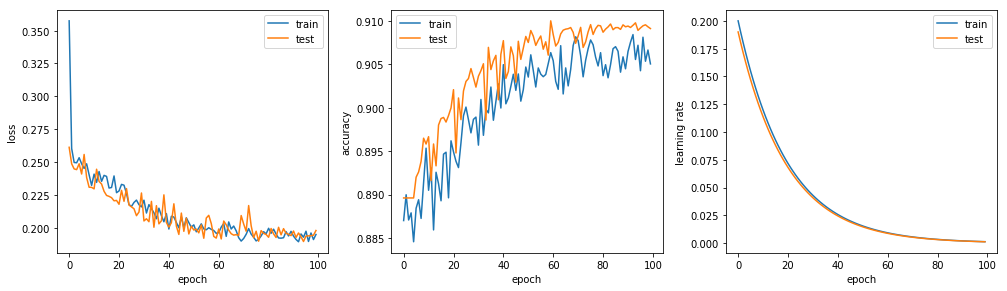

In [36]:
if (data_metric_isbi_2012 is not None):
    show_results(data_metric_isbi_2012)

In [37]:
#dataset/isbi-challenge/test-original/ PATH_ISBI_2012_TEST_ORIGINAL
data_provider_isbi_2012_test = ImageDataProvider(PATH_ISBI_2012_TEST_ORIGINAL + "*.tif")

Number of files used: 1


INFO:tensorflow:Restoring parameters from ./unet_trained_isbi_2012/model.ckpt


2018-10-09 23:39:06,609 Restoring parameters from ./unet_trained_isbi_2012/model.ckpt
2018-10-09 23:39:07,151 Model restored from file: ./unet_trained_isbi_2012/model.ckpt
2018-10-09 23:39:07,712 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-10-09 23:39:07,885 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


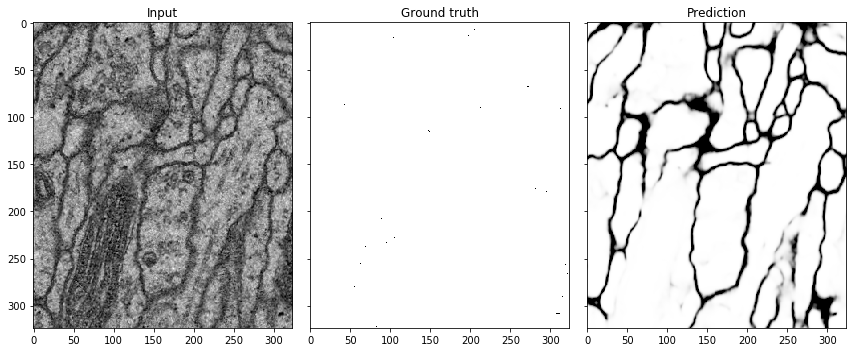

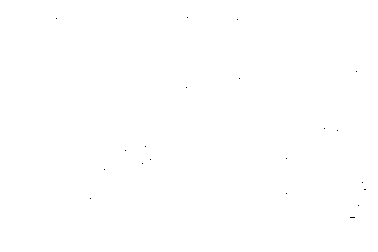

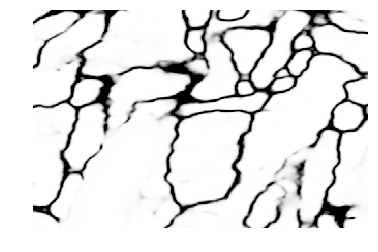

In [38]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test, TRAINED_FOLDER_ISBI_2012)

Test
- Utilizamos los labels reservados de la imagen original para poder hacer las comparaciones

In [39]:
data_provider_isbi_2012_test_mask = ImageDataProvider(PATH_ISBI_2012_FINAL_TEST + "/*/" + "*.tif")

Number of files used: 305


INFO:tensorflow:Restoring parameters from ./unet_trained_isbi_2012/model.ckpt


2018-10-09 23:39:21,043 Restoring parameters from ./unet_trained_isbi_2012/model.ckpt
2018-10-09 23:39:21,669 Model restored from file: ./unet_trained_isbi_2012/model.ckpt
2018-10-09 23:39:22,286 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-10-09 23:39:22,457 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


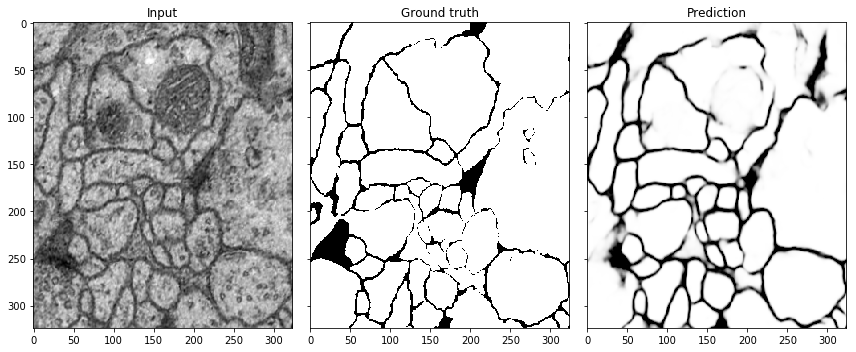

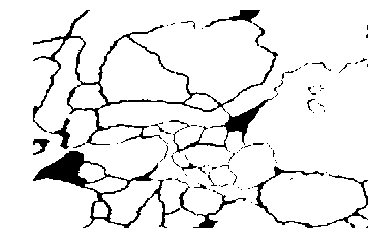

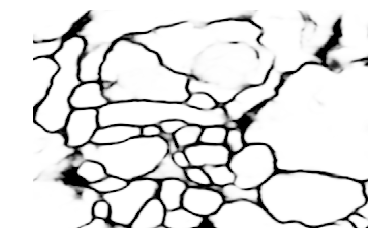

In [40]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test_mask, TRAINED_FOLDER_ISBI_2012)

### Cell Tracking Challenge (línea base)
- http://www.celltrackingchallenge.net/datasets.html
- Solo existe una imagen sin máscara
- Se necesitan buscar reemplazos de ambos conjuntos

PhC-U373 - PhC-C2DH-U373
- Glioblastoma-astrocytoma U373 cells on a polyacrylimide substrate  (2D)
- Dr. Sanjay Kumar. Department of Bioengineering
- University of California at Berkeley. Berkeley CA (USA)
- Microscope: Nikon
- Objective lens: Plan Fluor DLL 20X/0.5
- Pixel size (microns): 0.65 x 0.65
- Time step (min): 15

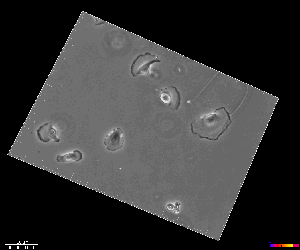

In [41]:
img = Image.open("img/PhC-C2DH-U373.gif")
img = img.resize((300, 250), Image.ANTIALIAS)
img

DIC-HeLA - Fluo-N2DL-HeLa
- HeLa cells stably expressing H2b-GFP (2D)
- Mitocheck Consortium
- Microscope: Olympus IX81
- Objective lens: Plan 10x/0.4
- Pixel size (microns): 0.645 x 0.645
- Time step (min): 30

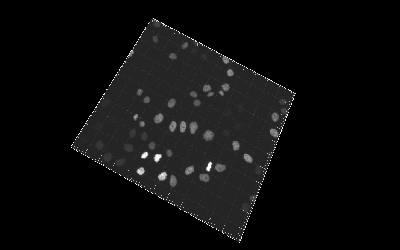

In [42]:
img = Image.open("img/N2DL-HeLa.gif")
img = img.resize((400, 250), Image.ANTIALIAS)
img

### Broad Bioimage Benchmark Collection (BBBC003)
- Embriones de ratones.
- Modo de toma: Fluor
- https://data.broadinstitute.org/bbbc/BBBC003/
- Existen diferentes conjuntos de datos
- Todas las imágenes deben tener la misma orientación (horizontal o vertical). Se modificaron manualmente.

In [50]:
PATH_BROAD_003_TRAIN = "dataset/broad-bioimage/BBBC003/train/"
PATH_BROAD_003_TEST = "dataset/broad-bioimage/BBBC003/test/"
TRAINED_FOLDER_BROAD_003 = "unet_trained_broad_003"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_003_MODEL = True

Train

In [51]:
data_provider_broad_003_train = ImageDataProvider(PATH_BROAD_003_TRAIN + "*.tif")

Number of files used: 11


In [52]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_003 = Pruebas();

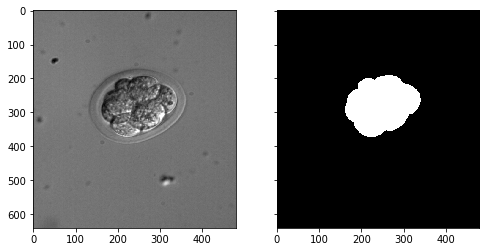

2018-10-09 23:41:06,841 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-10-09 23:41:09,673 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_broad_003'
2018-10-09 23:41:09,690 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_broad_003'
2018-10-09 23:41:09,691 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_broad_003'
2018-10-09 23:41:09,693 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_broad_003'
2018-10-09 23:41:12,780 Verification error= 79.9%, loss= 0.7242
2018-10-09 23:41:13,725 Start optimization
2018-10-09 23:41:16,554 Iter 0, Minibatch Loss= 0.6337, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-10-09 23:41:16,941 Iter 2, Minibatch Loss= 0.5363, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:41:17,326 Iter 4, Minibatch Loss= 0.4663, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-10-09 23:41:17,70

2018-10-09 23:41:50,956 Iter 130, Minibatch Loss= 0.4267, Training Accuracy= 0.8438, Minibatch error= 15.6%
2018-10-09 23:41:51,417 Iter 132, Minibatch Loss= 0.3762, Training Accuracy= 0.8730, Minibatch error= 12.7%
2018-10-09 23:41:51,906 Iter 134, Minibatch Loss= 0.3903, Training Accuracy= 0.8675, Minibatch error= 13.3%
2018-10-09 23:41:52,306 Iter 136, Minibatch Loss= 0.5564, Training Accuracy= 0.8201, Minibatch error= 18.0%
2018-10-09 23:41:52,753 Iter 138, Minibatch Loss= 0.4858, Training Accuracy= 0.8082, Minibatch error= 19.2%
2018-10-09 23:41:53,193 Iter 140, Minibatch Loss= 0.5647, Training Accuracy= 0.7435, Minibatch error= 25.7%
2018-10-09 23:41:53,590 Iter 142, Minibatch Loss= 0.4896, Training Accuracy= 0.8028, Minibatch error= 19.7%
2018-10-09 23:41:54,013 Iter 144, Minibatch Loss= 0.4939, Training Accuracy= 0.7981, Minibatch error= 20.2%
2018-10-09 23:41:54,456 Iter 146, Minibatch Loss= 0.4142, Training Accuracy= 0.8469, Minibatch error= 15.3%
2018-10-09 23:41:54,945 Iter

2018-10-09 23:42:27,205 Iter 270, Minibatch Loss= 0.4763, Training Accuracy= 0.8095, Minibatch error= 19.1%
2018-10-09 23:42:27,581 Iter 272, Minibatch Loss= 0.4957, Training Accuracy= 0.7976, Minibatch error= 20.2%
2018-10-09 23:42:27,977 Iter 274, Minibatch Loss= 0.4634, Training Accuracy= 0.8234, Minibatch error= 17.7%
2018-10-09 23:42:28,363 Iter 276, Minibatch Loss= 0.4548, Training Accuracy= 0.8266, Minibatch error= 17.3%
2018-10-09 23:42:28,752 Iter 278, Minibatch Loss= 0.5050, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:42:29,146 Iter 280, Minibatch Loss= 0.4942, Training Accuracy= 0.7983, Minibatch error= 20.2%
2018-10-09 23:42:29,540 Iter 282, Minibatch Loss= 0.4720, Training Accuracy= 0.8118, Minibatch error= 18.8%
2018-10-09 23:42:29,920 Iter 284, Minibatch Loss= 0.4792, Training Accuracy= 0.8054, Minibatch error= 19.5%
2018-10-09 23:42:30,298 Iter 286, Minibatch Loss= 0.4777, Training Accuracy= 0.8065, Minibatch error= 19.3%
2018-10-09 23:42:30,383 Epoc

2018-10-09 23:43:01,810 Iter 410, Minibatch Loss= 0.5139, Training Accuracy= 0.7841, Minibatch error= 21.6%
2018-10-09 23:43:02,184 Iter 412, Minibatch Loss= 0.5001, Training Accuracy= 0.7972, Minibatch error= 20.3%
2018-10-09 23:43:02,559 Iter 414, Minibatch Loss= 0.5103, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-10-09 23:43:02,644 Epoch 12, Average loss: 0.4964, learning rate: 0.1081
2018-10-09 23:43:03,140 Verification error= 20.1%, loss= 0.4940
2018-10-09 23:43:04,973 Iter 416, Minibatch Loss= 0.4558, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-10-09 23:43:05,338 Iter 418, Minibatch Loss= 0.4822, Training Accuracy= 0.8086, Minibatch error= 19.1%
2018-10-09 23:43:05,710 Iter 420, Minibatch Loss= 0.5716, Training Accuracy= 0.7428, Minibatch error= 25.7%
2018-10-09 23:43:06,135 Iter 422, Minibatch Loss= 0.5162, Training Accuracy= 0.7841, Minibatch error= 21.6%
2018-10-09 23:43:06,505 Iter 424, Minibatch Loss= 0.5104, Training Accuracy= 0.7849, Minibatch error= 

2018-10-09 23:43:38,855 Iter 548, Minibatch Loss= 0.4976, Training Accuracy= 0.7972, Minibatch error= 20.3%
2018-10-09 23:43:39,225 Iter 550, Minibatch Loss= 0.4494, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-10-09 23:43:39,595 Iter 552, Minibatch Loss= 0.4514, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-10-09 23:43:39,963 Iter 554, Minibatch Loss= 0.4537, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-10-09 23:43:40,336 Iter 556, Minibatch Loss= 0.5004, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-10-09 23:43:40,745 Iter 558, Minibatch Loss= 0.5055, Training Accuracy= 0.7841, Minibatch error= 21.6%
2018-10-09 23:43:41,120 Iter 560, Minibatch Loss= 0.5028, Training Accuracy= 0.7841, Minibatch error= 21.6%
2018-10-09 23:43:41,492 Iter 562, Minibatch Loss= 0.4467, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-10-09 23:43:41,868 Iter 564, Minibatch Loss= 0.5035, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:43:42,240 Iter

2018-10-09 23:44:14,605 Iter 688, Minibatch Loss= 0.4218, Training Accuracy= 0.8564, Minibatch error= 14.4%
2018-10-09 23:44:15,001 Iter 690, Minibatch Loss= 0.4011, Training Accuracy= 0.8754, Minibatch error= 12.5%
2018-10-09 23:44:15,424 Iter 692, Minibatch Loss= 0.4141, Training Accuracy= 0.8568, Minibatch error= 14.3%
2018-10-09 23:44:15,862 Iter 694, Minibatch Loss= 0.3964, Training Accuracy= 0.8759, Minibatch error= 12.4%
2018-10-09 23:44:16,255 Iter 696, Minibatch Loss= 0.3958, Training Accuracy= 0.8651, Minibatch error= 13.5%
2018-10-09 23:44:16,636 Iter 698, Minibatch Loss= 0.3679, Training Accuracy= 0.8794, Minibatch error= 12.1%
2018-10-09 23:44:17,017 Iter 700, Minibatch Loss= 0.4182, Training Accuracy= 0.8573, Minibatch error= 14.3%
2018-10-09 23:44:17,433 Iter 702, Minibatch Loss= 0.4315, Training Accuracy= 0.8475, Minibatch error= 15.2%
2018-10-09 23:44:17,520 Epoch 21, Average loss: 0.4395, learning rate: 0.0681
2018-10-09 23:44:18,011 Verification error= 19.3%, loss= 0

2018-10-09 23:44:50,742 Iter 828, Minibatch Loss= 0.4993, Training Accuracy= 0.8348, Minibatch error= 16.5%
2018-10-09 23:44:51,130 Iter 830, Minibatch Loss= 0.5016, Training Accuracy= 0.8106, Minibatch error= 18.9%
2018-10-09 23:44:51,217 Epoch 25, Average loss: 0.3896, learning rate: 0.0555
2018-10-09 23:44:51,733 Verification error= 19.2%, loss= 0.5198
2018-10-09 23:44:53,603 Iter 832, Minibatch Loss= 0.4688, Training Accuracy= 0.8391, Minibatch error= 16.1%
2018-10-09 23:44:53,983 Iter 834, Minibatch Loss= 0.4621, Training Accuracy= 0.8310, Minibatch error= 16.9%
2018-10-09 23:44:54,406 Iter 836, Minibatch Loss= 0.4573, Training Accuracy= 0.8283, Minibatch error= 17.2%
2018-10-09 23:44:54,804 Iter 838, Minibatch Loss= 0.5699, Training Accuracy= 0.7487, Minibatch error= 25.1%
2018-10-09 23:44:55,216 Iter 840, Minibatch Loss= 0.4474, Training Accuracy= 0.8369, Minibatch error= 16.3%
2018-10-09 23:44:55,645 Iter 842, Minibatch Loss= 0.4290, Training Accuracy= 0.8465, Minibatch error= 

2018-10-09 23:45:28,248 Iter 966, Minibatch Loss= 0.4907, Training Accuracy= 0.7972, Minibatch error= 20.3%
2018-10-09 23:45:28,661 Iter 968, Minibatch Loss= 0.4522, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-10-09 23:45:29,034 Iter 970, Minibatch Loss= 0.5014, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-10-09 23:45:29,446 Iter 972, Minibatch Loss= 0.4895, Training Accuracy= 0.7972, Minibatch error= 20.3%
2018-10-09 23:45:29,816 Iter 974, Minibatch Loss= 0.4999, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:45:30,230 Iter 976, Minibatch Loss= 0.4488, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-10-09 23:45:30,605 Iter 978, Minibatch Loss= 0.5013, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-10-09 23:45:30,980 Iter 980, Minibatch Loss= 0.4691, Training Accuracy= 0.8086, Minibatch error= 19.1%
2018-10-09 23:45:31,382 Iter 982, Minibatch Loss= 0.4438, Training Accuracy= 0.8259, Minibatch error= 17.4%
2018-10-09 23:45:31,755 Iter

2018-10-09 23:46:03,714 Iter 1106, Minibatch Loss= 0.4310, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-10-09 23:46:04,107 Iter 1108, Minibatch Loss= 0.4953, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:46:04,479 Iter 1110, Minibatch Loss= 0.4921, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-10-09 23:46:04,841 Iter 1112, Minibatch Loss= 0.4361, Training Accuracy= 0.8224, Minibatch error= 17.8%
2018-10-09 23:46:05,213 Iter 1114, Minibatch Loss= 0.5655, Training Accuracy= 0.7428, Minibatch error= 25.7%
2018-10-09 23:46:05,581 Iter 1116, Minibatch Loss= 0.4241, Training Accuracy= 0.8226, Minibatch error= 17.7%
2018-10-09 23:46:05,963 Iter 1118, Minibatch Loss= 0.4502, Training Accuracy= 0.8087, Minibatch error= 19.1%
2018-10-09 23:46:06,048 Epoch 34, Average loss: 0.4775, learning rate: 0.0350
2018-10-09 23:46:06,563 Verification error= 20.1%, loss= 0.4681
2018-10-09 23:46:08,637 Iter 1120, Minibatch Loss= 0.4253, Training Accuracy= 0.8259, Minibatch

2018-10-09 23:46:38,592 Iter 1244, Minibatch Loss= 0.4383, Training Accuracy= 0.8309, Minibatch error= 16.9%
2018-10-09 23:46:38,959 Iter 1246, Minibatch Loss= 0.4077, Training Accuracy= 0.8523, Minibatch error= 14.8%
2018-10-09 23:46:39,044 Epoch 38, Average loss: 0.4493, learning rate: 0.0285
2018-10-09 23:46:39,553 Verification error= 16.8%, loss= 0.4456
2018-10-09 23:46:41,602 Iter 1248, Minibatch Loss= 0.4381, Training Accuracy= 0.8365, Minibatch error= 16.4%
2018-10-09 23:46:41,975 Iter 1250, Minibatch Loss= 0.4576, Training Accuracy= 0.8325, Minibatch error= 16.8%
2018-10-09 23:46:42,374 Iter 1252, Minibatch Loss= 0.3886, Training Accuracy= 0.8668, Minibatch error= 13.3%
2018-10-09 23:46:42,794 Iter 1254, Minibatch Loss= 0.3946, Training Accuracy= 0.8615, Minibatch error= 13.9%
2018-10-09 23:46:43,167 Iter 1256, Minibatch Loss= 0.4419, Training Accuracy= 0.8316, Minibatch error= 16.8%
2018-10-09 23:46:43,544 Iter 1258, Minibatch Loss= 0.4408, Training Accuracy= 0.8435, Minibatch

2018-10-09 23:47:16,435 Iter 1380, Minibatch Loss= 0.3495, Training Accuracy= 0.8884, Minibatch error= 11.2%
2018-10-09 23:47:16,872 Iter 1382, Minibatch Loss= 0.3486, Training Accuracy= 0.8899, Minibatch error= 11.0%
2018-10-09 23:47:17,256 Iter 1384, Minibatch Loss= 0.3867, Training Accuracy= 0.8749, Minibatch error= 12.5%
2018-10-09 23:47:17,671 Iter 1386, Minibatch Loss= 0.3561, Training Accuracy= 0.8837, Minibatch error= 11.6%
2018-10-09 23:47:18,078 Iter 1388, Minibatch Loss= 0.4113, Training Accuracy= 0.8546, Minibatch error= 14.5%
2018-10-09 23:47:18,484 Iter 1390, Minibatch Loss= 0.3759, Training Accuracy= 0.8705, Minibatch error= 12.9%
2018-10-09 23:47:18,861 Iter 1392, Minibatch Loss= 0.3286, Training Accuracy= 0.8990, Minibatch error= 10.1%
2018-10-09 23:47:19,244 Iter 1394, Minibatch Loss= 0.3810, Training Accuracy= 0.8686, Minibatch error= 13.1%
2018-10-09 23:47:19,631 Iter 1396, Minibatch Loss= 0.3467, Training Accuracy= 0.8883, Minibatch error= 11.2%
2018-10-09 23:47:20

2018-10-09 23:47:53,563 Iter 1518, Minibatch Loss= 0.3501, Training Accuracy= 0.8799, Minibatch error= 12.0%
2018-10-09 23:47:53,950 Iter 1520, Minibatch Loss= 0.4141, Training Accuracy= 0.8444, Minibatch error= 15.6%
2018-10-09 23:47:54,330 Iter 1522, Minibatch Loss= 0.3844, Training Accuracy= 0.8596, Minibatch error= 14.0%
2018-10-09 23:47:54,716 Iter 1524, Minibatch Loss= 0.3535, Training Accuracy= 0.8744, Minibatch error= 12.6%
2018-10-09 23:47:55,099 Iter 1526, Minibatch Loss= 0.3622, Training Accuracy= 0.8714, Minibatch error= 12.9%
2018-10-09 23:47:55,486 Iter 1528, Minibatch Loss= 0.3624, Training Accuracy= 0.8690, Minibatch error= 13.1%
2018-10-09 23:47:55,879 Iter 1530, Minibatch Loss= 0.3956, Training Accuracy= 0.8547, Minibatch error= 14.5%
2018-10-09 23:47:56,258 Iter 1532, Minibatch Loss= 0.5232, Training Accuracy= 0.7830, Minibatch error= 21.7%
2018-10-09 23:47:56,643 Iter 1534, Minibatch Loss= 0.3361, Training Accuracy= 0.8878, Minibatch error= 11.2%
2018-10-09 23:47:56

In [53]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_003, data_metric_broad_003 = pruebas_broad_003.train(data_provider_broad_003_train, 
                                          TRAINED_FOLDER_BROAD_003, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum 
                                          ENTRENAR_BROAD_003_MODEL)

Métricas

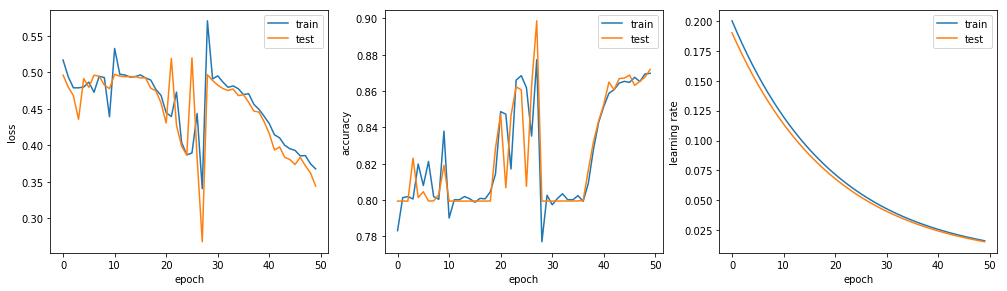

In [54]:
if (data_metric_isbi_2012 is not None):
    show_results(data_metric_broad_003)

Test

In [55]:
data_provider_broad_003_test = ImageDataProvider(PATH_BROAD_003_TEST + "*.tif")

Number of files used: 4


INFO:tensorflow:Restoring parameters from ./unet_trained_broad_003/model.ckpt


2018-10-09 23:48:18,037 Restoring parameters from ./unet_trained_broad_003/model.ckpt
2018-10-09 23:48:18,331 Model restored from file: ./unet_trained_broad_003/model.ckpt
2018-10-09 23:48:18,755 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-10-09 23:48:18,909 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


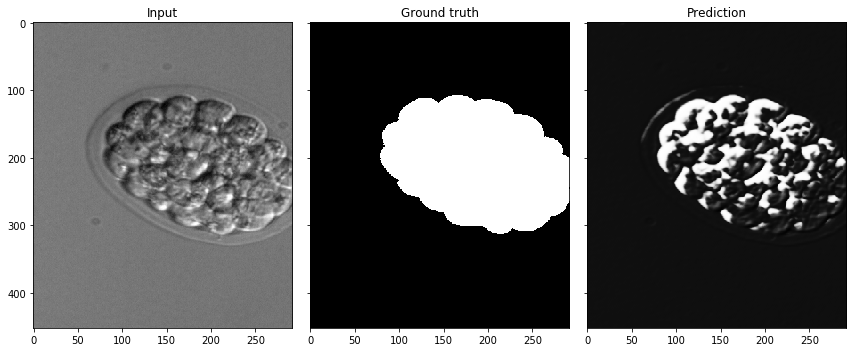

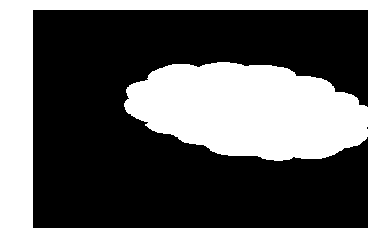

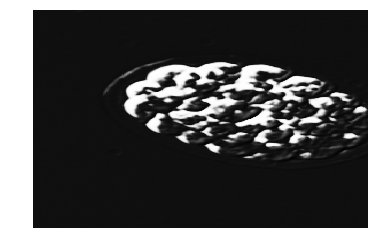

In [56]:
pruebas_broad_003.test(model_broad_003, data_provider_broad_003_test, TRAINED_FOLDER_BROAD_003)

### Broad Bioimage Benchmark Collection (BBBC005)
- https://data.broadinstitute.org/bbbc/image_sets.html
- Existen diferentes conjuntos de datos

In [57]:
PATH_BROAD_005_TRAIN = "dataset/broad-bioimage/BBBC005/train/"
PATH_BROAD_005_TEST = "dataset/broad-bioimage/BBBC005/test/"
TRAINED_FOLDER_BROAD_005 = "unet_trained_broad_005"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_005_MODEL = True

Train

In [58]:
data_provider_broad_005_train = ImageDataProvider(PATH_BROAD_005_TRAIN + "*.tif")

Number of files used: 28


In [59]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_005 = Pruebas();

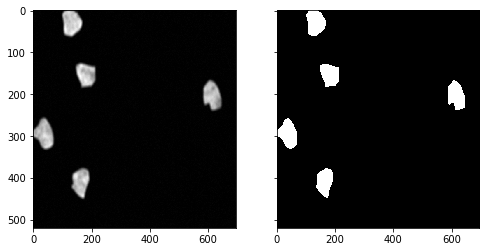

2018-10-09 23:48:19,721 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-10-09 23:48:22,030 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_broad_005'
2018-10-09 23:48:22,034 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_broad_005'
2018-10-09 23:48:22,036 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_broad_005'
2018-10-09 23:48:22,037 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_broad_005'
2018-10-09 23:48:25,414 Verification error= 97.6%, loss= 0.7376
2018-10-09 23:48:26,555 Start optimization
2018-10-09 23:48:29,420 Iter 0, Minibatch Loss= 0.5555, Training Accuracy= 0.9874, Minibatch error= 1.3%
2018-10-09 23:48:29,973 Iter 2, Minibatch Loss= 0.3637, Training Accuracy= 0.9312, Minibatch error= 6.9%
2018-10-09 23:48:30,564 Iter 4, Minibatch Loss= 0.0865, Training Accuracy= 0.9845, Minibatch error= 1.6%
2018-10-09 23:48:31,174 I

2018-10-09 23:49:08,958 Iter 130, Minibatch Loss= 0.0016, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-10-09 23:49:09,453 Iter 132, Minibatch Loss= 0.0031, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-10-09 23:49:09,911 Iter 134, Minibatch Loss= 0.0019, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-10-09 23:49:10,370 Iter 136, Minibatch Loss= 0.0023, Training Accuracy= 0.9991, Minibatch error= 0.1%
2018-10-09 23:49:10,830 Iter 138, Minibatch Loss= 0.0033, Training Accuracy= 0.9989, Minibatch error= 0.1%
2018-10-09 23:49:11,285 Iter 140, Minibatch Loss= 0.0028, Training Accuracy= 0.9989, Minibatch error= 0.1%
2018-10-09 23:49:11,739 Iter 142, Minibatch Loss= 0.0044, Training Accuracy= 0.9988, Minibatch error= 0.1%
2018-10-09 23:49:12,231 Iter 144, Minibatch Loss= 0.0050, Training Accuracy= 0.9981, Minibatch error= 0.2%
2018-10-09 23:49:12,691 Iter 146, Minibatch Loss= 0.0027, Training Accuracy= 0.9989, Minibatch error= 0.1%
2018-10-09 23:49:13,157 Iter 148, Min

2018-10-09 23:49:51,346 Iter 272, Minibatch Loss= 0.0058, Training Accuracy= 0.9976, Minibatch error= 0.2%
2018-10-09 23:49:51,797 Iter 274, Minibatch Loss= 0.0058, Training Accuracy= 0.9976, Minibatch error= 0.2%
2018-10-09 23:49:52,252 Iter 276, Minibatch Loss= 0.0049, Training Accuracy= 0.9980, Minibatch error= 0.2%
2018-10-09 23:49:52,710 Iter 278, Minibatch Loss= 0.0052, Training Accuracy= 0.9986, Minibatch error= 0.1%
2018-10-09 23:49:53,170 Iter 280, Minibatch Loss= 0.0012, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-10-09 23:49:53,659 Iter 282, Minibatch Loss= 0.0053, Training Accuracy= 0.9983, Minibatch error= 0.2%
2018-10-09 23:49:54,114 Iter 284, Minibatch Loss= 0.0040, Training Accuracy= 0.9983, Minibatch error= 0.2%
2018-10-09 23:49:54,608 Iter 286, Minibatch Loss= 0.0037, Training Accuracy= 0.9986, Minibatch error= 0.1%
2018-10-09 23:49:54,708 Epoch 8, Average loss: 0.0048, learning rate: 0.1327
2018-10-09 23:49:55,300 Verification error= 0.1%, loss= 0.0033
2018

2018-10-09 23:50:33,271 Iter 414, Minibatch Loss= 0.0063, Training Accuracy= 0.9976, Minibatch error= 0.2%
2018-10-09 23:50:33,374 Epoch 12, Average loss: 0.0045, learning rate: 0.1081
2018-10-09 23:50:33,988 Verification error= 0.1%, loss= 0.0030
2018-10-09 23:50:35,966 Iter 416, Minibatch Loss= 0.0019, Training Accuracy= 0.9993, Minibatch error= 0.1%
2018-10-09 23:50:36,446 Iter 418, Minibatch Loss= 0.0021, Training Accuracy= 0.9991, Minibatch error= 0.1%
2018-10-09 23:50:36,924 Iter 420, Minibatch Loss= 0.0027, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-10-09 23:50:37,375 Iter 422, Minibatch Loss= 0.0052, Training Accuracy= 0.9979, Minibatch error= 0.2%
2018-10-09 23:50:37,817 Iter 424, Minibatch Loss= 0.0026, Training Accuracy= 0.9989, Minibatch error= 0.1%
2018-10-09 23:50:38,299 Iter 426, Minibatch Loss= 0.0018, Training Accuracy= 0.9993, Minibatch error= 0.1%
2018-10-09 23:50:38,790 Iter 428, Minibatch Loss= 0.0034, Training Accuracy= 0.9989, Minibatch error= 0.1%
201

2018-10-09 23:51:15,643 Iter 552, Minibatch Loss= 0.0026, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-10-09 23:51:16,091 Iter 554, Minibatch Loss= 0.0042, Training Accuracy= 0.9984, Minibatch error= 0.2%
2018-10-09 23:51:16,538 Iter 556, Minibatch Loss= 0.0054, Training Accuracy= 0.9977, Minibatch error= 0.2%
2018-10-09 23:51:16,981 Iter 558, Minibatch Loss= 0.0014, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-10-09 23:51:17,430 Iter 560, Minibatch Loss= 0.0020, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-10-09 23:51:17,872 Iter 562, Minibatch Loss= 0.0018, Training Accuracy= 0.9993, Minibatch error= 0.1%
2018-10-09 23:51:18,323 Iter 564, Minibatch Loss= 0.0053, Training Accuracy= 0.9978, Minibatch error= 0.2%
2018-10-09 23:51:18,814 Iter 566, Minibatch Loss= 0.0022, Training Accuracy= 0.9991, Minibatch error= 0.1%
2018-10-09 23:51:19,251 Iter 568, Minibatch Loss= 0.0026, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-10-09 23:51:19,692 Iter 570, Min

In [60]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_005, data_metric_broad_005 = pruebas_broad_005.train(data_provider_broad_005_train, 
                                          TRAINED_FOLDER_BROAD_005, 
                                          32, #iterations
                                          20, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum
                                          ENTRENAR_BROAD_005_MODEL)

Métricas

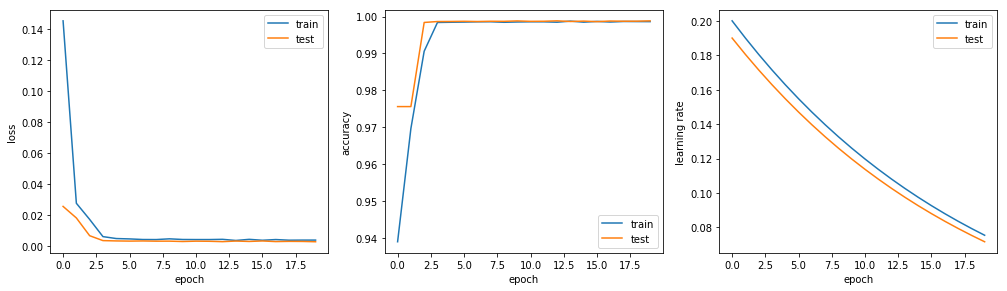

In [61]:
if (data_metric_broad_005 is not None):
    show_results(data_metric_broad_005)

Test

In [62]:
data_provider_broad_005_test = ImageDataProvider(PATH_BROAD_005_TEST + "*.tif")

Number of files used: 28


INFO:tensorflow:Restoring parameters from ./unet_trained_broad_005/model.ckpt


2018-10-09 23:51:43,178 Restoring parameters from ./unet_trained_broad_005/model.ckpt
2018-10-09 23:51:43,370 Model restored from file: ./unet_trained_broad_005/model.ckpt
/home/droneulima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/droneulima/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


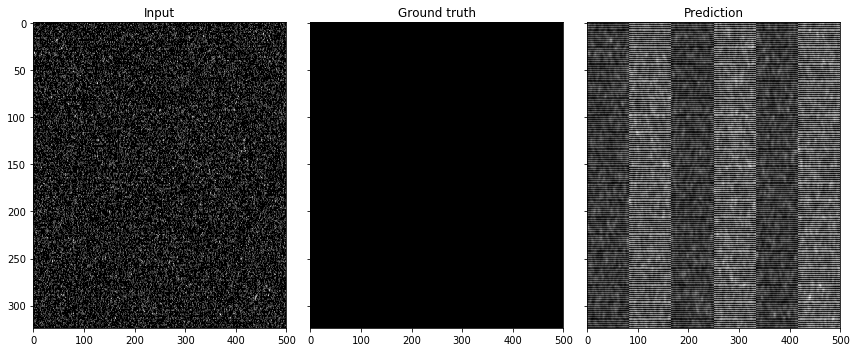

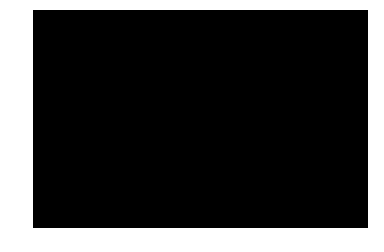

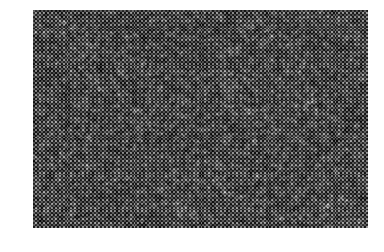

In [63]:
pruebas_broad_005.test(model_broad_005, data_provider_broad_005_test, TRAINED_FOLDER_BROAD_005)

###  Electron Microscopy Dataset
- Tomas del hipocampo
- Fuente: https://cvlab.epfl.ch/data/data-em/
- Resolución: 1024 x 768 x 165
- Podría ser utilizado como complemento del dataset EM segmentation challenge - ISBI 2012
- Se ha corrido con 10 épocas y aún no logra buenos resultados (hay que probarlo en la nube)

In [64]:
PATH_ELECTRON_MICROSCOPY_TRAIN = "dataset/electron-microscopy/train/"
PATH_ELECTRON_MICROSCOPY_TEST = "dataset/electron-microscopy/test/"
TRAINED_FOLDER_ELECTRON_MICROSCOPY = "unet_trained_electron_microscopy"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_ELECTRON_MICROSCOPY_MODEL =True

Los archivos pesan más de 100mb, por lo que no podremos integrarlos al repositorio. Se procede a descargarlos por única vez.

In [65]:
#Descargar imágenes
URL_ELECTRON_MICROSCOPY_TRAIN = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training.tif"
URL_ELECTRON_MICROSCOPY_TRAIN_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training_groundtruth.tif"
URL_ELECTRON_MICROSCOPY_TEST = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing.tif"
URL_ELECTRON_MICROSCOPY_TEST_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing_groundtruth.tif"

def crear_carpetas():
    try:
        os.mkdir("dataset/electron-microscopy/")
        os.mkdir("dataset/electron-microscopy/train") 
        os.mkdir("dataset/electron-microscopy/test") 
        print("Las carpetas han sido creadas")
    except:
        print("Ya están creadas las carpetas")
        
def descargar_imagen(url, path):
    if not os.path.exists(path):
        print("Descargando " + path)
        wget.download(url=url, out=path)

In [66]:
crear_carpetas()
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN, 'dataset/electron-microscopy/train/training.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN_MASK, 'dataset/electron-microscopy/train/training_mask.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST, 'dataset/electron-microscopy/test/testing.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST_MASK, 'dataset/electron-microscopy/test/testing_mask.tif')

Las carpetas han sido creadas
Descargando dataset/electron-microscopy/train/training.tif
Descargando dataset/electron-microscopy/train/training_mask.tif
Descargando dataset/electron-microscopy/test/testing.tif
Descargando dataset/electron-microscopy/test/testing_mask.tif


Train

In [67]:
data_provider_electron_microscopy_train = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TRAIN + "*.tif")

Number of files used: 1


In [68]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_electron_microscopy = Pruebas();

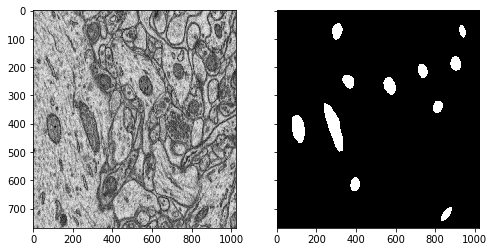

2018-10-09 23:59:39,118 Layers 5, features 16, filter size 3x3, pool size: 2x2
2018-10-09 23:59:41,370 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_electron_microscopy'
2018-10-09 23:59:41,395 Removing '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_electron_microscopy'
2018-10-09 23:59:41,397 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/prediction_unet_trained_electron_microscopy'
2018-10-09 23:59:41,399 Allocating '/home/droneulima/notebooks/Kevin/V6/segmentacion-unet/unet_trained_electron_microscopy'
2018-10-09 23:59:45,598 Verification error= 6.7%, loss= 0.6685
2018-10-09 23:59:48,327 Start optimization
2018-10-09 23:59:52,072 Iter 0, Minibatch Loss= 0.5986, Training Accuracy= 0.9296, Minibatch error= 7.0%
2018-10-09 23:59:52,816 Iter 2, Minibatch Loss= 0.3449, Training Accuracy= 0.9560, Minibatch error= 4.4%
2018-10-09 23:59:53,638 Iter 4, Minibatch Loss= 0.2008, Training Accuracy= 0.9459, Minibatc

2018-10-10 00:01:01,050 Iter 130, Minibatch Loss= 0.1756, Training Accuracy= 0.9367, Minibatch error= 6.3%
2018-10-10 00:01:01,931 Iter 132, Minibatch Loss= 0.2196, Training Accuracy= 0.9103, Minibatch error= 9.0%
2018-10-10 00:01:02,826 Iter 134, Minibatch Loss= 0.1413, Training Accuracy= 0.9513, Minibatch error= 4.9%
2018-10-10 00:01:03,671 Iter 136, Minibatch Loss= 0.1532, Training Accuracy= 0.9474, Minibatch error= 5.3%
2018-10-10 00:01:04,520 Iter 138, Minibatch Loss= 0.2040, Training Accuracy= 0.9226, Minibatch error= 7.7%
2018-10-10 00:01:05,338 Iter 140, Minibatch Loss= 0.1330, Training Accuracy= 0.9566, Minibatch error= 4.3%
2018-10-10 00:01:06,209 Iter 142, Minibatch Loss= 0.1828, Training Accuracy= 0.9359, Minibatch error= 6.4%
2018-10-10 00:01:07,054 Iter 144, Minibatch Loss= 0.2103, Training Accuracy= 0.9136, Minibatch error= 8.6%
2018-10-10 00:01:07,929 Iter 146, Minibatch Loss= 0.1342, Training Accuracy= 0.9542, Minibatch error= 4.6%
2018-10-10 00:01:08,773 Iter 148, Min

2018-10-10 00:02:15,595 Iter 272, Minibatch Loss= 0.1528, Training Accuracy= 0.9151, Minibatch error= 8.5%
2018-10-10 00:02:16,374 Iter 274, Minibatch Loss= 0.1557, Training Accuracy= 0.9226, Minibatch error= 7.7%
2018-10-10 00:02:17,117 Iter 276, Minibatch Loss= 0.0813, Training Accuracy= 0.9578, Minibatch error= 4.2%
2018-10-10 00:02:17,868 Iter 278, Minibatch Loss= 0.1410, Training Accuracy= 0.9408, Minibatch error= 5.9%
2018-10-10 00:02:18,702 Iter 280, Minibatch Loss= 0.1528, Training Accuracy= 0.9151, Minibatch error= 8.5%
2018-10-10 00:02:19,454 Iter 282, Minibatch Loss= 0.1633, Training Accuracy= 0.9129, Minibatch error= 8.7%
2018-10-10 00:02:20,216 Iter 284, Minibatch Loss= 0.0795, Training Accuracy= 0.9588, Minibatch error= 4.1%
2018-10-10 00:02:21,062 Iter 286, Minibatch Loss= 0.1350, Training Accuracy= 0.9442, Minibatch error= 5.6%
2018-10-10 00:02:21,241 Epoch 8, Average loss: 0.1442, learning rate: 0.1327
2018-10-10 00:02:22,418 Verification error= 6.7%, loss= 0.1298
2018

2018-10-10 00:03:26,348 Iter 414, Minibatch Loss= 0.1445, Training Accuracy= 0.9477, Minibatch error= 5.2%
2018-10-10 00:03:26,524 Epoch 12, Average loss: 0.1285, learning rate: 0.1081
2018-10-10 00:03:27,653 Verification error= 4.6%, loss= 0.1164
2018-10-10 00:03:30,959 Iter 416, Minibatch Loss= 0.1054, Training Accuracy= 0.9542, Minibatch error= 4.6%
2018-10-10 00:03:31,745 Iter 418, Minibatch Loss= 0.1329, Training Accuracy= 0.9496, Minibatch error= 5.0%
2018-10-10 00:03:32,550 Iter 420, Minibatch Loss= 0.1225, Training Accuracy= 0.9414, Minibatch error= 5.9%
2018-10-10 00:03:33,302 Iter 422, Minibatch Loss= 0.0905, Training Accuracy= 0.9607, Minibatch error= 3.9%
2018-10-10 00:03:34,035 Iter 424, Minibatch Loss= 0.0749, Training Accuracy= 0.9734, Minibatch error= 2.7%
2018-10-10 00:03:34,817 Iter 426, Minibatch Loss= 0.1033, Training Accuracy= 0.9536, Minibatch error= 4.6%
2018-10-10 00:03:35,601 Iter 428, Minibatch Loss= 0.1377, Training Accuracy= 0.9495, Minibatch error= 5.0%
201

2018-10-10 00:04:37,749 Iter 552, Minibatch Loss= 0.1072, Training Accuracy= 0.9561, Minibatch error= 4.4%
2018-10-10 00:04:38,451 Iter 554, Minibatch Loss= 0.0750, Training Accuracy= 0.9729, Minibatch error= 2.7%
2018-10-10 00:04:39,158 Iter 556, Minibatch Loss= 0.1176, Training Accuracy= 0.9483, Minibatch error= 5.2%
2018-10-10 00:04:39,857 Iter 558, Minibatch Loss= 0.0731, Training Accuracy= 0.9738, Minibatch error= 2.6%
2018-10-10 00:04:40,622 Iter 560, Minibatch Loss= 0.1123, Training Accuracy= 0.9572, Minibatch error= 4.3%
2018-10-10 00:04:41,379 Iter 562, Minibatch Loss= 0.1337, Training Accuracy= 0.9479, Minibatch error= 5.2%
2018-10-10 00:04:42,108 Iter 564, Minibatch Loss= 0.0861, Training Accuracy= 0.9685, Minibatch error= 3.1%
2018-10-10 00:04:42,840 Iter 566, Minibatch Loss= 0.1244, Training Accuracy= 0.9524, Minibatch error= 4.8%
2018-10-10 00:04:43,559 Iter 568, Minibatch Loss= 0.1218, Training Accuracy= 0.9561, Minibatch error= 4.4%
2018-10-10 00:04:44,261 Iter 570, Min

2018-10-10 00:05:46,404 Iter 694, Minibatch Loss= 0.0974, Training Accuracy= 0.9558, Minibatch error= 4.4%
2018-10-10 00:05:47,119 Iter 696, Minibatch Loss= 0.1071, Training Accuracy= 0.9544, Minibatch error= 4.6%
2018-10-10 00:05:47,825 Iter 698, Minibatch Loss= 0.0722, Training Accuracy= 0.9706, Minibatch error= 2.9%
2018-10-10 00:05:48,583 Iter 700, Minibatch Loss= 0.0563, Training Accuracy= 0.9800, Minibatch error= 2.0%
2018-10-10 00:05:49,303 Iter 702, Minibatch Loss= 0.0861, Training Accuracy= 0.9639, Minibatch error= 3.6%
2018-10-10 00:05:49,482 Epoch 21, Average loss: 0.1065, learning rate: 0.0681
2018-10-10 00:05:50,662 Verification error= 4.0%, loss= 0.0980
2018-10-10 00:05:54,027 Iter 704, Minibatch Loss= 0.0591, Training Accuracy= 0.9791, Minibatch error= 2.1%
2018-10-10 00:05:54,760 Iter 706, Minibatch Loss= 0.1011, Training Accuracy= 0.9653, Minibatch error= 3.5%
2018-10-10 00:05:55,498 Iter 708, Minibatch Loss= 0.1045, Training Accuracy= 0.9548, Minibatch error= 4.5%
201

2018-10-10 00:06:55,902 Iter 832, Minibatch Loss= 0.0742, Training Accuracy= 0.9712, Minibatch error= 2.9%
2018-10-10 00:06:56,614 Iter 834, Minibatch Loss= 0.0735, Training Accuracy= 0.9699, Minibatch error= 3.0%
2018-10-10 00:06:57,321 Iter 836, Minibatch Loss= 0.0955, Training Accuracy= 0.9616, Minibatch error= 3.8%
2018-10-10 00:06:58,075 Iter 838, Minibatch Loss= 0.0703, Training Accuracy= 0.9687, Minibatch error= 3.1%
2018-10-10 00:06:58,777 Iter 840, Minibatch Loss= 0.1018, Training Accuracy= 0.9604, Minibatch error= 4.0%
2018-10-10 00:06:59,480 Iter 842, Minibatch Loss= 0.0943, Training Accuracy= 0.9685, Minibatch error= 3.1%
2018-10-10 00:07:00,169 Iter 844, Minibatch Loss= 0.0914, Training Accuracy= 0.9671, Minibatch error= 3.3%
2018-10-10 00:07:00,873 Iter 846, Minibatch Loss= 0.0493, Training Accuracy= 0.9809, Minibatch error= 1.9%
2018-10-10 00:07:01,568 Iter 848, Minibatch Loss= 0.0899, Training Accuracy= 0.9696, Minibatch error= 3.0%
2018-10-10 00:07:02,252 Iter 850, Min

2018-10-10 00:08:04,201 Iter 974, Minibatch Loss= 0.0873, Training Accuracy= 0.9705, Minibatch error= 3.0%
2018-10-10 00:08:04,929 Iter 976, Minibatch Loss= 0.1052, Training Accuracy= 0.9579, Minibatch error= 4.2%
2018-10-10 00:08:05,651 Iter 978, Minibatch Loss= 0.0897, Training Accuracy= 0.9621, Minibatch error= 3.8%
2018-10-10 00:08:06,372 Iter 980, Minibatch Loss= 0.0990, Training Accuracy= 0.9607, Minibatch error= 3.9%
2018-10-10 00:08:07,086 Iter 982, Minibatch Loss= 0.0486, Training Accuracy= 0.9808, Minibatch error= 1.9%
2018-10-10 00:08:07,810 Iter 984, Minibatch Loss= 0.0442, Training Accuracy= 0.9847, Minibatch error= 1.5%
2018-10-10 00:08:08,534 Iter 986, Minibatch Loss= 0.0866, Training Accuracy= 0.9703, Minibatch error= 3.0%
2018-10-10 00:08:09,259 Iter 988, Minibatch Loss= 0.0536, Training Accuracy= 0.9801, Minibatch error= 2.0%
2018-10-10 00:08:09,987 Iter 990, Minibatch Loss= 0.0824, Training Accuracy= 0.9705, Minibatch error= 2.9%
2018-10-10 00:08:10,174 Epoch 30, Ave

2018-10-10 00:09:10,757 Iter 1114, Minibatch Loss= 0.0752, Training Accuracy= 0.9718, Minibatch error= 2.8%
2018-10-10 00:09:11,492 Iter 1116, Minibatch Loss= 0.0896, Training Accuracy= 0.9657, Minibatch error= 3.4%
2018-10-10 00:09:12,233 Iter 1118, Minibatch Loss= 0.0791, Training Accuracy= 0.9660, Minibatch error= 3.4%
2018-10-10 00:09:12,412 Epoch 34, Average loss: 0.0863, learning rate: 0.0350
2018-10-10 00:09:13,434 Verification error= 3.1%, loss= 0.0781
2018-10-10 00:09:16,671 Iter 1120, Minibatch Loss= 0.0907, Training Accuracy= 0.9565, Minibatch error= 4.3%
2018-10-10 00:09:17,360 Iter 1122, Minibatch Loss= 0.0771, Training Accuracy= 0.9717, Minibatch error= 2.8%
2018-10-10 00:09:18,067 Iter 1124, Minibatch Loss= 0.0427, Training Accuracy= 0.9844, Minibatch error= 1.6%
2018-10-10 00:09:18,763 Iter 1126, Minibatch Loss= 0.0745, Training Accuracy= 0.9752, Minibatch error= 2.5%
2018-10-10 00:09:19,455 Iter 1128, Minibatch Loss= 0.0695, Training Accuracy= 0.9734, Minibatch error= 

2018-10-10 00:10:20,165 Iter 1252, Minibatch Loss= 0.0511, Training Accuracy= 0.9806, Minibatch error= 1.9%
2018-10-10 00:10:20,853 Iter 1254, Minibatch Loss= 0.0953, Training Accuracy= 0.9623, Minibatch error= 3.8%
2018-10-10 00:10:21,556 Iter 1256, Minibatch Loss= 0.0443, Training Accuracy= 0.9838, Minibatch error= 1.6%
2018-10-10 00:10:22,259 Iter 1258, Minibatch Loss= 0.0569, Training Accuracy= 0.9769, Minibatch error= 2.3%
2018-10-10 00:10:22,961 Iter 1260, Minibatch Loss= 0.0765, Training Accuracy= 0.9732, Minibatch error= 2.7%
2018-10-10 00:10:23,636 Iter 1262, Minibatch Loss= 0.1335, Training Accuracy= 0.9514, Minibatch error= 4.9%
2018-10-10 00:10:24,314 Iter 1264, Minibatch Loss= 0.0801, Training Accuracy= 0.9715, Minibatch error= 2.8%
2018-10-10 00:10:25,019 Iter 1266, Minibatch Loss= 0.0829, Training Accuracy= 0.9673, Minibatch error= 3.3%
2018-10-10 00:10:25,713 Iter 1268, Minibatch Loss= 0.0881, Training Accuracy= 0.9684, Minibatch error= 3.2%
2018-10-10 00:10:26,415 Iter

2018-10-10 00:11:27,496 Iter 1392, Minibatch Loss= 0.0411, Training Accuracy= 0.9855, Minibatch error= 1.5%
2018-10-10 00:11:28,188 Iter 1394, Minibatch Loss= 0.0812, Training Accuracy= 0.9701, Minibatch error= 3.0%
2018-10-10 00:11:28,931 Iter 1396, Minibatch Loss= 0.0928, Training Accuracy= 0.9663, Minibatch error= 3.4%
2018-10-10 00:11:29,667 Iter 1398, Minibatch Loss= 0.0716, Training Accuracy= 0.9673, Minibatch error= 3.3%
2018-10-10 00:11:30,371 Iter 1400, Minibatch Loss= 0.0998, Training Accuracy= 0.9642, Minibatch error= 3.6%
2018-10-10 00:11:31,159 Iter 1402, Minibatch Loss= 0.0735, Training Accuracy= 0.9665, Minibatch error= 3.4%
2018-10-10 00:11:31,947 Iter 1404, Minibatch Loss= 0.0731, Training Accuracy= 0.9691, Minibatch error= 3.1%
2018-10-10 00:11:32,702 Iter 1406, Minibatch Loss= 0.0453, Training Accuracy= 0.9837, Minibatch error= 1.6%
2018-10-10 00:11:32,883 Epoch 43, Average loss: 0.0738, learning rate: 0.0220
2018-10-10 00:11:33,909 Verification error= 2.9%, loss= 0.

2018-10-10 00:12:34,308 Iter 1532, Minibatch Loss= 0.0403, Training Accuracy= 0.9858, Minibatch error= 1.4%
2018-10-10 00:12:35,078 Iter 1534, Minibatch Loss= 0.1139, Training Accuracy= 0.9541, Minibatch error= 4.6%
2018-10-10 00:12:35,257 Epoch 47, Average loss: 0.0629, learning rate: 0.0179
2018-10-10 00:12:36,317 Verification error= 2.5%, loss= 0.0710
2018-10-10 00:12:39,955 Iter 1536, Minibatch Loss= 0.1037, Training Accuracy= 0.9579, Minibatch error= 4.2%
2018-10-10 00:12:40,643 Iter 1538, Minibatch Loss= 0.0702, Training Accuracy= 0.9709, Minibatch error= 2.9%
2018-10-10 00:12:41,337 Iter 1540, Minibatch Loss= 0.0581, Training Accuracy= 0.9789, Minibatch error= 2.1%
2018-10-10 00:12:42,021 Iter 1542, Minibatch Loss= 0.0961, Training Accuracy= 0.9699, Minibatch error= 3.0%
2018-10-10 00:12:42,711 Iter 1544, Minibatch Loss= 0.0709, Training Accuracy= 0.9730, Minibatch error= 2.7%
2018-10-10 00:12:43,459 Iter 1546, Minibatch Loss= 0.0688, Training Accuracy= 0.9749, Minibatch error= 

In [69]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#Ej. 40 iteraciones x 4 batch size = 160 ejemplos. Tenemos 165 frames en la imagen
#Recomendaciones de batch: https://www.quora.com/What-are-the-usual-batch-sizes-people-use-to-train-neural-nets                     
#########################
model_electron_microscopy, data_metric_electron_microscopy = pruebas_electron_microscopy.train(data_provider_electron_microscopy_train, 
                                          TRAINED_FOLDER_ELECTRON_MICROSCOPY, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          16, #features
                                          0.5, #momentum 
                                          ENTRENAR_ELECTRON_MICROSCOPY_MODEL)

Métricas

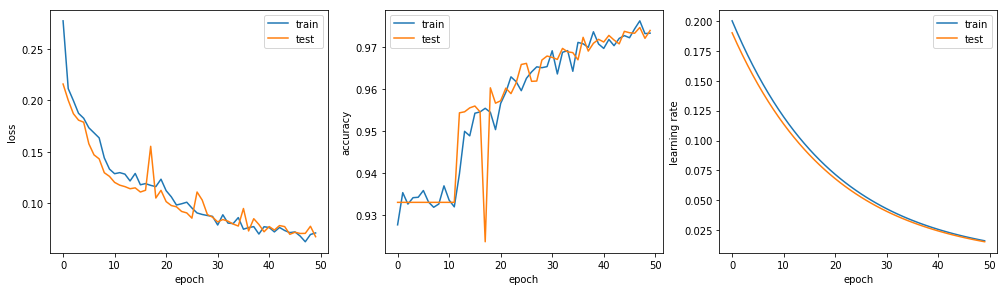

In [70]:
if (data_metric_electron_microscopy is not None):
    show_results(data_metric_electron_microscopy)

Test

In [71]:
data_provider_electron_microscopy_test = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TEST + "*.tif")

Number of files used: 1


INFO:tensorflow:Restoring parameters from ./unet_trained_electron_microscopy/model.ckpt


2018-10-10 00:13:12,263 Restoring parameters from ./unet_trained_electron_microscopy/model.ckpt
2018-10-10 00:13:12,526 Model restored from file: ./unet_trained_electron_microscopy/model.ckpt
2018-10-10 00:13:13,100 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-10-10 00:13:13,290 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


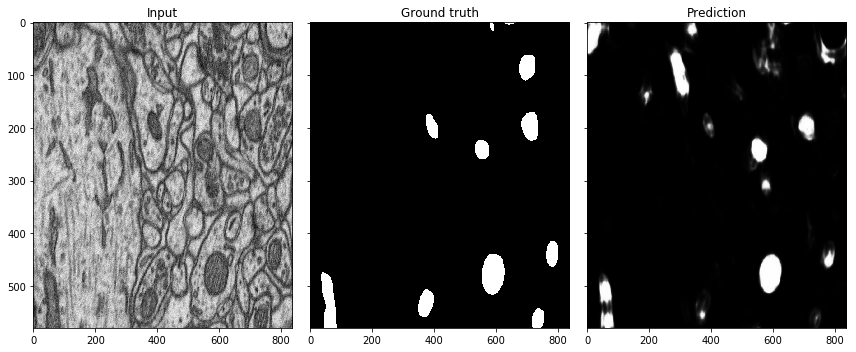

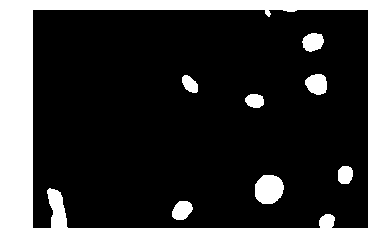

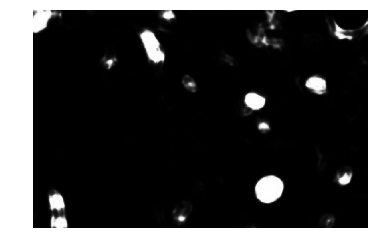

In [72]:
pruebas_electron_microscopy.test(model_electron_microscopy, 
                                 data_provider_electron_microscopy_test, 
                                 TRAINED_FOLDER_ELECTRON_MICROSCOPY)